In [1]:
import wandb
wandb.login(key="39ded67ba2685c0f85010b40d27298a712244e64")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Preethi\_netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="DeepLearning1", name="GradientDescent")

In [26]:
wandb.finish()

# visualising dataset

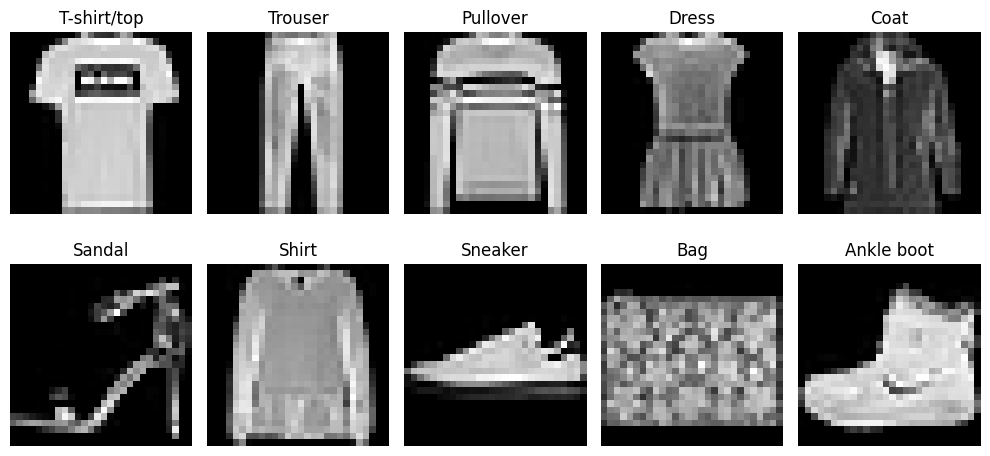

In [24]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Defining class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sample_images = []
sample_labels = []

for class_id in range(10):
    index = np.where(y_train == class_id)[0][0]  # Get the first occurrence of the class
    sample_images.append(x_train[index])
    sample_labels.append(class_names[class_id])

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(sample_labels[i])
    plt.axis('off')

plt.tight_layout()

wandb.init(project="DeepLearning1", name="question1 image")

# Save figure before logging
plt.savefig("dataset.png")  
wandb.log({
    "dataset": wandb.Image("dataset.png")  # Log saved image
})

# Show the plot
plt.show()

# Finish wandb run
wandb.finish()


# Feed Forward 

In [4]:
import numpy as np
import pandas as pd
import wandb

x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)  # Flatten

# One-hot encoding labels
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        """
        Initialize the neural network with given architecture.
        :param input_size: Number of input features
        :param hidden_layers: List where each element is the number of neurons in a hidden layer
        :param output_size: Number of output classes
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        """
        Forward propagation.
        :param X: Input data
        :return: Activations for each layer
        """
        activations = {0: X}
        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            activations[i + 1] = self.relu(Z)
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        activations[len(self.layers) - 1] = self.softmax(Z_out)
        return activations

    def backward(self, X, Y, activations, learning_rate):
        """
        Backpropagation algorithm.
        :param X: Input data
        :param Y: True labels
        :param activations: Forward pass activations
        :param learning_rate: Step size for gradient descent
        """
        grads = {}
        m = X.shape[0]
        L = len(self.layers) - 1

        # Compute output layer gradient
        dZ = activations[L] - Y
        grads['dW' + str(L - 1)] = np.dot(activations[L - 1].T, dZ) / m
        grads['db' + str(L - 1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(L - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i + 1].T) * self.relu_derivative(activations[i + 1])
            grads['dW' + str(i)] = np.dot(activations[i].T, dZ) / m
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases
        for i in range(L):
            self.weights[i] -= learning_rate * grads['dW' + str(i)]
            self.biases[i] -= learning_rate * grads['db' + str(i)]

    def compute_loss(self, Y_true, Y_pred):
        """
        Compute cross-entropy loss.
        """
        m = Y_true.shape[0]
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m

    def train(self, X, Y, epochs=50, batch_size=64, learning_rate=0.01):
        """
        Train the model using mini-batch gradient descent.
        """
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, Y_shuffled = X[indices], Y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]
                activations = self.forward(X_batch)
                self.backward(X_batch, Y_batch, activations, learning_rate)

            # # Log loss to wandb every 10 epochs
            # if epoch % 10 == 0:
            Y_pred = self.forward(X)[len(self.layers) - 1]
            loss = self.compute_loss(Y, Y_pred)
            wandb.log({"epoch": epoch, "loss": loss})
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        """
        Predict class labels.
        """
        activations = self.forward(X)
        return np.argmax(activations[len(self.layers) - 1], axis=1)

# Create and train the network
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)
nn.train(x_train, y_train_onehot, epochs=50, batch_size=64, learning_rate=0.01)

# Evaluation on test set
y_pred = nn.predict(x_test)
accuracy = np.mean(y_pred == y_test)
wandb.log({"Test Accuracy": accuracy})  # Log test accuracy
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 0, Loss: 2.3002
Epoch 1, Loss: 2.0391
Epoch 2, Loss: 1.1643
Epoch 3, Loss: 0.9051
Epoch 4, Loss: 0.8116
Epoch 5, Loss: 0.7714
Epoch 6, Loss: 0.7226
Epoch 7, Loss: 0.6443
Epoch 8, Loss: 0.5907
Epoch 9, Loss: 0.5755
Epoch 10, Loss: 0.5573
Epoch 11, Loss: 0.5495
Epoch 12, Loss: 0.5255
Epoch 13, Loss: 0.5185
Epoch 14, Loss: 0.4896
Epoch 15, Loss: 0.4811
Epoch 16, Loss: 0.4775
Epoch 17, Loss: 0.4624
Epoch 18, Loss: 0.4525
Epoch 19, Loss: 0.4351
Epoch 20, Loss: 0.4274
Epoch 21, Loss: 0.4445
Epoch 22, Loss: 0.4350
Epoch 23, Loss: 0.4144
Epoch 24, Loss: 0.4244
Epoch 25, Loss: 0.3946
Epoch 26, Loss: 0.3981
Epoch 27, Loss: 0.3772
Epoch 28, Loss: 0.3920
Epoch 29, Loss: 0.3846
Epoch 30, Loss: 0.4330
Epoch 31, Loss: 0.3682
Epoch 32, Loss: 0.3620
Epoch 33, Loss: 0.3587
Epoch 34, Loss: 0.3481
Epoch 35, Loss: 0.3487
Epoch 36, Loss: 0.3715
Epoch 37, Loss: 0.3355
Epoch 38, Loss: 0.3353
Epoch 39, Loss: 0.3650
Epoch 40, Loss: 0.3439
Epoch 41, Loss: 0.3298
Epoch 42, Loss: 0.3268
Epoch 43, Loss: 0.325

# Different Optimizers

In [5]:
import numpy as np
import wandb
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1) 

num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, optimizer="sgd", learning_rate=0.01):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = {}
        self.biases = {}

        # initializing weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))

        # Storing gradients and optimization parameters
        self.velocities = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.squared_gradients = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.m_t = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.v_t = {i: np.zeros_like(self.weights[i]) for i in self.weights}

        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.beta1 = 0.9 
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        activations = {0: X}
        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            activations[i + 1] = self.relu(Z)
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        activations[len(self.layers) - 1] = self.softmax(Z_out)
        return activations

    def backward(self, activations, Y_true):
        grads = {}
        L = len(self.layers) - 1
        m = Y_true.shape[0]

        # gradient for output layer
        dZ = activations[L] - Y_true
        grads['dW' + str(L - 1)] = np.dot(activations[L - 1].T, dZ) / m
        grads['db' + str(L - 1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(L - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i + 1].T) * self.relu_derivative(activations[i + 1])
            grads['dW' + str(i)] = np.dot(activations[i].T, dZ) / m
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

        return grads

    def update_weights(self, grads, t):
        for i in self.weights:
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads['dW' + str(i)]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "momentum":
                self.velocities[i] = self.beta1 * self.velocities[i] - self.learning_rate * grads['dW' + str(i)]
                self.weights[i] += self.velocities[i]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "nesterov":
                prev_velocity = self.velocities[i]
                self.velocities[i] = self.beta1 * self.velocities[i] - self.learning_rate * grads['dW' + str(i)]
                self.weights[i] += -self.beta1 * prev_velocity + (1 + self.beta1) * self.velocities[i]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "rmsprop":
                self.squared_gradients[i] = self.beta2 * self.squared_gradients[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                self.weights[i] -= self.learning_rate * grads['dW' + str(i)] / (np.sqrt(self.squared_gradients[i]) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "adam":
                self.m_t[i] = self.beta1 * self.m_t[i] + (1 - self.beta1) * grads['dW' + str(i)]
                self.v_t[i] = self.beta2 * self.v_t[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                m_hat = self.m_t[i] / (1 - self.beta1 ** t)
                v_hat = self.v_t[i] / (1 - self.beta2 ** t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "nadam":
                m_hat = self.beta1 * self.m_t[i] + (1 - self.beta1) * grads['dW' + str(i)]
                v_hat = self.beta2 * self.v_t[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                self.weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * grads['dW' + str(i)] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat / (1 - self.beta2 ** t)) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

    def compute_loss(self, Y_true, Y_pred):
        m = Y_true.shape[0]
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m

    def train(self, X, Y, epochs=50, batch_size=64):
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, Y_shuffled = X[indices], Y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]
                activations = self.forward(X_batch)
                grads = self.backward(activations, Y_batch)
                self.update_weights(grads, epoch + 1)

            loss = self.compute_loss(Y, self.forward(X)[len(self.layers) - 1])
            wandb.log({"epoch": epoch, "loss": loss})
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

optimizers = ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]

for opt in optimizers:
    wandb.init(project="DeepLearning1", name=f"Optimizer-{opt}", reinit=True)
    print(f"\nTraining with optimizer: {opt}")
    nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, optimizer=opt, learning_rate=0.001)
    nn.train(x_train, y_train_onehot, epochs=50, batch_size=64)


Test Accuracy,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.8692
epoch,49
loss,0.29658



Training with optimizer: sgd
Epoch 0, Loss: 2.3025
Epoch 1, Loss: 2.3023
Epoch 2, Loss: 2.3021
Epoch 3, Loss: 2.3020
Epoch 4, Loss: 2.3017
Epoch 5, Loss: 2.3015
Epoch 6, Loss: 2.3011
Epoch 7, Loss: 2.3006
Epoch 8, Loss: 2.2999
Epoch 9, Loss: 2.2989
Epoch 10, Loss: 2.2973
Epoch 11, Loss: 2.2946
Epoch 12, Loss: 2.2897
Epoch 13, Loss: 2.2794
Epoch 14, Loss: 2.2563
Epoch 15, Loss: 2.2069
Epoch 16, Loss: 2.1337
Epoch 17, Loss: 2.0503
Epoch 18, Loss: 1.9270
Epoch 19, Loss: 1.7541
Epoch 20, Loss: 1.6087
Epoch 21, Loss: 1.4845
Epoch 22, Loss: 1.3833
Epoch 23, Loss: 1.3083
Epoch 24, Loss: 1.2518
Epoch 25, Loss: 1.2068
Epoch 26, Loss: 1.1697
Epoch 27, Loss: 1.1370
Epoch 28, Loss: 1.1084
Epoch 29, Loss: 1.0806
Epoch 30, Loss: 1.0533
Epoch 31, Loss: 1.0292
Epoch 32, Loss: 0.9996
Epoch 33, Loss: 0.9716
Epoch 34, Loss: 0.9445
Epoch 35, Loss: 0.9211
Epoch 36, Loss: 0.9003
Epoch 37, Loss: 0.8853
Epoch 38, Loss: 0.8692
Epoch 39, Loss: 0.8580
Epoch 40, Loss: 0.8503
Epoch 41, Loss: 0.8401
Epoch 42, Loss

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█████████████▇▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.78482



Training with optimizer: momentum
Epoch 0, Loss: 2.2974
Epoch 1, Loss: 1.9331
Epoch 2, Loss: 1.0233
Epoch 3, Loss: 0.8891
Epoch 4, Loss: 0.8221
Epoch 5, Loss: 0.7885
Epoch 6, Loss: 0.6880
Epoch 7, Loss: 0.6286
Epoch 8, Loss: 0.5972
Epoch 9, Loss: 0.5693
Epoch 10, Loss: 0.5684
Epoch 11, Loss: 0.5331
Epoch 12, Loss: 0.5140
Epoch 13, Loss: 0.4995
Epoch 14, Loss: 0.4892
Epoch 15, Loss: 0.4838
Epoch 16, Loss: 0.4667
Epoch 17, Loss: 0.4774
Epoch 18, Loss: 0.4537
Epoch 19, Loss: 0.4426
Epoch 20, Loss: 0.4347
Epoch 21, Loss: 0.4338
Epoch 22, Loss: 0.4201
Epoch 23, Loss: 0.4098
Epoch 24, Loss: 0.4091
Epoch 25, Loss: 0.4001
Epoch 26, Loss: 0.3892
Epoch 27, Loss: 0.4027
Epoch 28, Loss: 0.3781
Epoch 29, Loss: 0.3745
Epoch 30, Loss: 0.3754
Epoch 31, Loss: 0.3650
Epoch 32, Loss: 0.3632
Epoch 33, Loss: 0.3708
Epoch 34, Loss: 0.3562
Epoch 35, Loss: 0.3465
Epoch 36, Loss: 0.3441
Epoch 37, Loss: 0.3367
Epoch 38, Loss: 0.3336
Epoch 39, Loss: 0.3367
Epoch 40, Loss: 0.3221
Epoch 41, Loss: 0.3243
Epoch 42,

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.30448



Training with optimizer: nesterov
Epoch 0, Loss: 2.3001
Epoch 1, Loss: 2.0639
Epoch 2, Loss: 1.1614
Epoch 3, Loss: 0.9190
Epoch 4, Loss: 0.8584
Epoch 5, Loss: 0.8231
Epoch 6, Loss: 0.7985
Epoch 7, Loss: 0.7157
Epoch 8, Loss: 0.6414
Epoch 9, Loss: 0.5971
Epoch 10, Loss: 0.5856
Epoch 11, Loss: 0.5547
Epoch 12, Loss: 0.5378
Epoch 13, Loss: 0.5217
Epoch 14, Loss: 0.5124
Epoch 15, Loss: 0.4973
Epoch 16, Loss: 0.4877
Epoch 17, Loss: 0.4857
Epoch 18, Loss: 0.4744
Epoch 19, Loss: 0.4596
Epoch 20, Loss: 0.4680
Epoch 21, Loss: 0.4408
Epoch 22, Loss: 0.4362
Epoch 23, Loss: 0.4295
Epoch 24, Loss: 0.4283
Epoch 25, Loss: 0.4244
Epoch 26, Loss: 0.4066
Epoch 27, Loss: 0.4026
Epoch 28, Loss: 0.3958
Epoch 29, Loss: 0.4073
Epoch 30, Loss: 0.3950
Epoch 31, Loss: 0.3885
Epoch 32, Loss: 0.3765
Epoch 33, Loss: 0.3891
Epoch 34, Loss: 0.3742
Epoch 35, Loss: 0.3602
Epoch 36, Loss: 0.3560
Epoch 37, Loss: 0.3510
Epoch 38, Loss: 0.3535
Epoch 39, Loss: 0.3453
Epoch 40, Loss: 0.3489
Epoch 41, Loss: 0.3455
Epoch 42,

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.31797



Training with optimizer: rmsprop
Epoch 0, Loss: 0.4247
Epoch 1, Loss: 0.3711
Epoch 2, Loss: 0.3337
Epoch 3, Loss: 0.3381
Epoch 4, Loss: 0.2999
Epoch 5, Loss: 0.3061
Epoch 6, Loss: 0.3423
Epoch 7, Loss: 0.3096
Epoch 8, Loss: 0.2634
Epoch 9, Loss: 0.2594
Epoch 10, Loss: 0.2409
Epoch 11, Loss: 0.2343
Epoch 12, Loss: 0.2385
Epoch 13, Loss: 0.2291
Epoch 14, Loss: 0.2192
Epoch 15, Loss: 0.2164
Epoch 16, Loss: 0.2157
Epoch 17, Loss: 0.2122
Epoch 18, Loss: 0.2047
Epoch 19, Loss: 0.1968
Epoch 20, Loss: 0.1973
Epoch 21, Loss: 0.1912
Epoch 22, Loss: 0.1834
Epoch 23, Loss: 0.1937
Epoch 24, Loss: 0.2049
Epoch 25, Loss: 0.1985
Epoch 26, Loss: 0.1684
Epoch 27, Loss: 0.1704
Epoch 28, Loss: 0.1923
Epoch 29, Loss: 0.1644
Epoch 30, Loss: 0.2044
Epoch 31, Loss: 0.1951
Epoch 32, Loss: 0.1663
Epoch 33, Loss: 0.1488
Epoch 34, Loss: 0.1745
Epoch 35, Loss: 0.1502
Epoch 36, Loss: 0.1606
Epoch 37, Loss: 0.1552
Epoch 38, Loss: 0.1537
Epoch 39, Loss: 0.1489
Epoch 40, Loss: 0.1356
Epoch 41, Loss: 0.1429
Epoch 42, 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂
epoch,49
loss,0.1244



Training with optimizer: adam
Epoch 0, Loss: 0.5467
Epoch 1, Loss: 0.4955
Epoch 2, Loss: 0.4581
Epoch 3, Loss: 0.4373
Epoch 4, Loss: 0.4265
Epoch 5, Loss: 0.4088
Epoch 6, Loss: 0.4000
Epoch 7, Loss: 0.3896
Epoch 8, Loss: 0.3954
Epoch 9, Loss: 0.3760
Epoch 10, Loss: 0.3703
Epoch 11, Loss: 0.3615
Epoch 12, Loss: 0.3560
Epoch 13, Loss: 0.3502
Epoch 14, Loss: 0.3435
Epoch 15, Loss: 0.3395
Epoch 16, Loss: 0.3372
Epoch 17, Loss: 0.3356
Epoch 18, Loss: 0.3264
Epoch 19, Loss: 0.3274
Epoch 20, Loss: 0.3197
Epoch 21, Loss: 0.3188
Epoch 22, Loss: 0.3113
Epoch 23, Loss: 0.3087
Epoch 24, Loss: 0.3040
Epoch 25, Loss: 0.3003
Epoch 26, Loss: 0.2963
Epoch 27, Loss: 0.2926
Epoch 28, Loss: 0.2994
Epoch 29, Loss: 0.2886
Epoch 30, Loss: 0.2851
Epoch 31, Loss: 0.2803
Epoch 32, Loss: 0.2868
Epoch 33, Loss: 0.2778
Epoch 34, Loss: 0.2702
Epoch 35, Loss: 0.2679
Epoch 36, Loss: 0.2717
Epoch 37, Loss: 0.2727
Epoch 38, Loss: 0.2608
Epoch 39, Loss: 0.2729
Epoch 40, Loss: 0.2636
Epoch 41, Loss: 0.2585
Epoch 42, Los

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,49
loss,0.23149



Training with optimizer: nadam
Epoch 0, Loss: 0.5965
Epoch 1, Loss: 0.5201
Epoch 2, Loss: 0.5339
Epoch 3, Loss: 0.6372
Epoch 4, Loss: 0.6763
Epoch 5, Loss: 0.6668
Epoch 6, Loss: 0.7095
Epoch 7, Loss: 0.8105
Epoch 8, Loss: 0.8313
Epoch 9, Loss: 0.7821
Epoch 10, Loss: 0.8281
Epoch 11, Loss: 0.8458
Epoch 12, Loss: 0.9268
Epoch 13, Loss: 0.9297
Epoch 14, Loss: 1.1763
Epoch 15, Loss: 1.1860
Epoch 16, Loss: 0.9441
Epoch 17, Loss: 1.0165
Epoch 18, Loss: 0.9367
Epoch 19, Loss: 0.9160
Epoch 20, Loss: 1.0906
Epoch 21, Loss: 1.1326
Epoch 22, Loss: 1.2764
Epoch 23, Loss: 1.0408
Epoch 24, Loss: 1.0265
Epoch 25, Loss: 1.1792
Epoch 26, Loss: 1.0270
Epoch 27, Loss: 1.0534
Epoch 28, Loss: 1.2105
Epoch 29, Loss: 1.5464
Epoch 30, Loss: 1.3060
Epoch 31, Loss: 1.8762
Epoch 32, Loss: 1.4756
Epoch 33, Loss: 1.3319
Epoch 34, Loss: 1.3216
Epoch 35, Loss: 1.1289
Epoch 36, Loss: 2.1217
Epoch 37, Loss: 2.8746
Epoch 38, Loss: 4.1611
Epoch 39, Loss: 3.4812
Epoch 40, Loss: 4.0734
Epoch 41, Loss: 3.0471
Epoch 42, Lo

# Sweep with different parameters,using bayesian optmization to eliminate poor models

In [6]:
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0,1]
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)  # Flatten

# One-hot encode labels
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# Split into training (90%) and validation (10%)
val_size = int(0.1 * x_train.shape[0])
x_val, y_val_onehot = x_train[:val_size], y_train_onehot[:val_size]
x_train, y_train_onehot = x_train[val_size:], y_train_onehot[val_size:]

# Define the sweep configuration
sweep_config = {
    "method": "bayes",  # Bayesian Optimization
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="DeepLearning1")


Create sweep with ID: qc8hcwnw
Sweep URL: https://wandb.ai/mm21b051-iitmaana/DeepLearning1/sweeps/qc8hcwnw


In [ ]:
import numpy as np
import wandb

def initialize_weights(shape, method):
    """Initialize weights using Xavier or small random values."""
    if method == "xavier":
        return np.random.randn(*shape) * np.sqrt(1 / shape[0])
    else:
        return np.random.randn(*shape) * 0.01

class NeuralNetwork:
    def __init__(self, config):
        input_size = 784  # MNIST images are 28x28
        output_size = 10   # 10 classes (digits 0-9)
        self.layers = [input_size] + [config.hidden_size] * config.hidden_layers + [output_size]
        self.activation_func = config.activation
        self.optimizer = config.optimizer
        self.learning_rate = config.learning_rate
        self.weight_decay = config.weight_decay
        self.batch_size = config.batch_size
        self.epochs = config.epochs
        self.beta1 = 0.5
        self.beta2 = 0.5
        self.momentum = 0.5
        self.epsilon = 0.000001	
        # Initialize weights and biases
        self.weights = {}
        self.biases = {}
        for i in range(len(self.layers) - 1):
            self.weights[i] = initialize_weights((self.layers[i], self.layers[i+1]), config.weight_init)
            self.biases[i] = np.zeros((1, self.layers[i+1]))
            
        self.velocities = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.squared_gradients = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.m_t = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.v_t = {i: np.zeros_like(self.weights[i]) for i in self.weights}

        

    def activation(self, Z):
        """Applies activation function."""
        if self.activation_func == "relu":
            return np.maximum(0, Z)
        elif self.activation_func == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        elif self.activation_func == "tanh":
            return np.tanh(Z)

    def activation_derivative(self, Z):
        """Computes derivative of activation function based on pre-activation Z."""
        if self.activation_func == "relu":
            return (Z > 0).astype(float)  # Derivative of ReLU is 1 for Z > 0, else 0
        elif self.activation_func == "sigmoid":
            A = 1 / (1 + np.exp(-Z))  # Compute sigmoid(Z)
            return A * (1 - A)  # Correct derivative
        elif self.activation_func == "tanh":
            A = np.tanh(Z)  # Compute tanh(Z)
            return 1 - A**2  # Correct derivative


    def softmax(self, Z):
        """Numerically stable softmax function."""
        Z -= np.max(Z, axis=1, keepdims=True)  # Prevent overflow
        exp_Z = np.exp(Z)
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward(self, X):
        """Performs forward propagation."""
        activations = {0: X}
        pre_activations = {}  # Store pre-activation values (Z)

        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            pre_activations[i + 1] = Z  # Save Z before activation
            activations[i + 1] = self.activation(Z)

        # Output layer with softmax
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        pre_activations[len(self.layers) - 1] = Z_out  # Save final layer pre-activation
        activations[len(self.layers) - 1] = self.softmax(Z_out)

        return activations, pre_activations

    def backward(self, activations, pre_activations, Y_true):
        grads = {}
        L = len(self.layers) - 1
        m = Y_true.shape[0]

        # Compute gradient for output layer
        dZ = activations[L] - Y_true
        grads['dW' + str(L - 1)] = np.dot(activations[L - 1].T, dZ) / m
        grads['db' + str(L - 1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(L - 2, -1, -1):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.activation_derivative(pre_activations[i + 1])  # Correct usage of Z
            grads['dW' + str(i)] = np.dot(activations[i].T, dZ) / m
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

        return grads

    def update_weights(self, grads, t):
        for i in self.weights:
            before_update = np.linalg.norm(self.weights[i])  # Compute norm before update

            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads['dW' + str(i)]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "momentum":
                self.velocities[i] = self.beta1 * self.velocities[i] - self.learning_rate * grads['dW' + str(i)]
                self.weights[i] += self.velocities[i]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "nesterov":
                prev_velocity = self.velocities[i]
                self.velocities[i] = self.beta1 * self.velocities[i] - self.learning_rate * grads['dW' + str(i)]
                self.weights[i] += -self.beta1 * prev_velocity + (1 + self.beta1) * self.velocities[i]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "rmsprop":
                self.squared_gradients[i] = self.beta2 * self.squared_gradients[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                self.weights[i] -= self.learning_rate * grads['dW' + str(i)] / (np.sqrt(self.squared_gradients[i]) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "adam":
                self.m_t[i] = self.beta1 * self.m_t[i] + (1 - self.beta1) * grads['dW' + str(i)]
                self.v_t[i] = self.beta2 * self.v_t[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                m_hat = self.m_t[i] / (1 - self.beta1 ** t)
                v_hat = self.v_t[i] / (1 - self.beta2 ** t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "nadam":
                m_hat = self.beta1 * self.m_t[i] + (1 - self.beta1) * grads['dW' + str(i)]
                v_hat = self.beta2 * self.v_t[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                self.weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * grads['dW' + str(i)] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat / (1 - self.beta2 ** t)) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]


    def compute_loss(self, Y_true, Y_pred):
        """Computes categorical cross-entropy loss."""
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / Y_true.shape[0]  # Avoid log(0) error

    def compute_accuracy(self, Y_true, Y_pred):
        """Computes accuracy given true labels and predicted probabilities."""
        Y_pred_labels = np.argmax(Y_pred, axis=1)
        Y_true_labels = np.argmax(Y_true, axis=1)
        return np.mean(Y_pred_labels == Y_true_labels)

    def train(self):
        """Train the neural network and log metrics using wandb."""
        for epoch in range(self.epochs):
            # Forward pass
            activations, pre_activations = self.forward(x_train)
            train_loss = self.compute_loss(y_train_onehot, activations[len(self.layers) - 1])
            train_accuracy = self.compute_accuracy(y_train_onehot, activations[len(self.layers) - 1])

            # Backward pass & update
            grads = self.backward(activations, pre_activations, y_train_onehot)
            self.update_weights(grads, epoch + 1)

            # Validation metrics
            val_activations, _ = self.forward(x_val)
            val_loss = self.compute_loss(y_val_onehot, val_activations[len(self.layers) - 1])
            val_accuracy = self.compute_accuracy(y_val_onehot, val_activations[len(self.layers) - 1])

            # Log metrics
            wandb.log({
                "epoch": epoch,
                "training_loss": train_loss,
                "training_accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            })

            # Print progress
            print(f"Epoch {epoch+1}/{self.epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")



In [ ]:
def sweep_train():
    with wandb.init() as run:
        config = wandb.config
        # Create a meaningful name for the sweep
        run.name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        model = NeuralNetwork(config)
        model.train()

wandb.agent(sweep_id, function=sweep_train, count=100)

wandb: Agent Starting Run: bpl6w530 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 2/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 3/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 4/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 5/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 6/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 7/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 8/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 9/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990
Epoch 10/10 | Train Loss: 2.3027, Train Acc: 0.1001 | Val Loss: 2.3027, Val Acc: 0.0990


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▆▅▅▄▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▅▄▄▂▂▁
epoch,9
training_accuracy,0.10011
training_loss,2.30271
val_accuracy,0.099
val_loss,2.30267


wandb: Agent Starting Run: g9ovokzu with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3345, Train Acc: 0.0969 | Val Loss: 2.3350, Val Acc: 0.0953
Epoch 2/5 | Train Loss: 2.3344, Train Acc: 0.0969 | Val Loss: 2.3350, Val Acc: 0.0953
Epoch 3/5 | Train Loss: 2.3344, Train Acc: 0.0969 | Val Loss: 2.3349, Val Acc: 0.0953
Epoch 4/5 | Train Loss: 2.3343, Train Acc: 0.0969 | Val Loss: 2.3349, Val Acc: 0.0953
Epoch 5/5 | Train Loss: 2.3343, Train Acc: 0.0969 | Val Loss: 2.3348, Val Acc: 0.0953


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁▁
training_loss,█▇▅▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▅▃▁
epoch,4
training_accuracy,0.09693
training_loss,2.33425
val_accuracy,0.09533
val_loss,2.33481


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vovxnie6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5 | Train Loss: 2.3051, Train Acc: 0.1007 | Val Loss: 2.3040, Val Acc: 0.0983
Epoch 2/5 | Train Loss: 2.3031, Train Acc: 0.1002 | Val Loss: 2.3025, Val Acc: 0.1013
Epoch 3/5 | Train Loss: 2.3028, Train Acc: 0.0999 | Val Loss: 2.3024, Val Acc: 0.1020
Epoch 4/5 | Train Loss: 2.3030, Train Acc: 0.0998 | Val Loss: 2.3025, Val Acc: 0.1072
Epoch 5/5 | Train Loss: 2.3027, Train Acc: 0.0992 | Val Loss: 2.3030, Val Acc: 0.0933


epoch,▁▃▅▆█
training_accuracy,█▅▄▄▁
training_loss,█▂▁▂▁
val_accuracy,▄▅▅█▁
val_loss,█▁▁▂▄
epoch,4
training_accuracy,0.0992
training_loss,2.30268
val_accuracy,0.09333
val_loss,2.30304


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gz6k8290 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 2/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 3/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 4/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 5/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 6/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 7/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 8/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 9/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262
Epoch 10/10 | Train Loss: 2.3026, Train Acc: 0.0257 | Val Loss: 2.3026, Val Acc: 0.0262


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▆▆▆█▆▆▆▆▆
training_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,9
training_accuracy,0.02572
training_loss,2.30259
val_accuracy,0.02617
val_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwnnyv7t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3026, Train Acc: 0.1478 | Val Loss: 2.3026, Val Acc: 0.1845
Epoch 2/10 | Train Loss: 2.3026, Train Acc: 0.1880 | Val Loss: 2.3026, Val Acc: 0.2140
Epoch 3/10 | Train Loss: 2.3026, Train Acc: 0.2155 | Val Loss: 2.3026, Val Acc: 0.2472
Epoch 4/10 | Train Loss: 2.3026, Train Acc: 0.2575 | Val Loss: 2.3026, Val Acc: 0.2933
Epoch 5/10 | Train Loss: 2.3026, Train Acc: 0.3002 | Val Loss: 2.3026, Val Acc: 0.3145
Epoch 6/10 | Train Loss: 2.3026, Train Acc: 0.3227 | Val Loss: 2.3026, Val Acc: 0.3238
Epoch 7/10 | Train Loss: 2.3026, Train Acc: 0.3305 | Val Loss: 2.3026, Val Acc: 0.3258
Epoch 8/10 | Train Loss: 2.3026, Train Acc: 0.3312 | Val Loss: 2.3026, Val Acc: 0.3270
Epoch 9/10 | Train Loss: 2.3026, Train Acc: 0.3302 | Val Loss: 2.3026, Val Acc: 0.3272
Epoch 10/10 | Train Loss: 2.3026, Train Acc: 0.3293 | Val Loss: 2.3026, Val Acc: 0.3247


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▇█████
training_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▂▄▆▇█████
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,9
training_accuracy,0.32926
training_loss,2.30257
val_accuracy,0.32467
val_loss,2.30257


wandb: Agent Starting Run: f5z3huy5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 2/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 3/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 4/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 5/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 6/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 7/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 8/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 9/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933
Epoch 10/10 | Train Loss: 2.3046, Train Acc: 0.1007 | Val Loss: 2.3059, Val Acc: 0.0933


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▆▅▅▄▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.10074
training_loss,2.30458
val_accuracy,0.09333
val_loss,2.30591


wandb: Agent Starting Run: bo4k00ks with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3026, Train Acc: 0.1579 | Val Loss: 2.3026, Val Acc: 0.2198
Epoch 2/10 | Train Loss: 2.3026, Train Acc: 0.2196 | Val Loss: 2.3026, Val Acc: 0.2433
Epoch 3/10 | Train Loss: 2.3026, Train Acc: 0.2411 | Val Loss: 2.3026, Val Acc: 0.2580
Epoch 4/10 | Train Loss: 2.3026, Train Acc: 0.2605 | Val Loss: 2.3025, Val Acc: 0.2807
Epoch 5/10 | Train Loss: 2.3025, Train Acc: 0.2839 | Val Loss: 2.3025, Val Acc: 0.2988
Epoch 6/10 | Train Loss: 2.3025, Train Acc: 0.3009 | Val Loss: 2.3025, Val Acc: 0.3067
Epoch 7/10 | Train Loss: 2.3025, Train Acc: 0.3097 | Val Loss: 2.3025, Val Acc: 0.3110
Epoch 8/10 | Train Loss: 2.3025, Train Acc: 0.3095 | Val Loss: 2.3025, Val Acc: 0.3057
Epoch 9/10 | Train Loss: 2.3025, Train Acc: 0.3029 | Val Loss: 2.3025, Val Acc: 0.2873
Epoch 10/10 | Train Loss: 2.3025, Train Acc: 0.2878 | Val Loss: 2.3024, Val Acc: 0.2630


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇████▇
training_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▃▄▆▇███▆▄
val_loss,██▇▇▆▅▄▃▂▁
epoch,9
training_accuracy,0.28778
training_loss,2.30246
val_accuracy,0.263
val_loss,2.30243


wandb: Agent Starting Run: ail26mvl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3044, Train Acc: 0.1001 | Val Loss: 2.3038, Val Acc: 0.0990
Epoch 2/10 | Train Loss: 2.3041, Train Acc: 0.1001 | Val Loss: 2.3037, Val Acc: 0.0990
Epoch 3/10 | Train Loss: 2.3040, Train Acc: 0.1001 | Val Loss: 2.3036, Val Acc: 0.0990
Epoch 4/10 | Train Loss: 2.3038, Train Acc: 0.1001 | Val Loss: 2.3035, Val Acc: 0.0990
Epoch 5/10 | Train Loss: 2.3037, Train Acc: 0.1001 | Val Loss: 2.3034, Val Acc: 0.0990
Epoch 6/10 | Train Loss: 2.3036, Train Acc: 0.1001 | Val Loss: 2.3033, Val Acc: 0.0990
Epoch 7/10 | Train Loss: 2.3035, Train Acc: 0.1001 | Val Loss: 2.3033, Val Acc: 0.0990
Epoch 8/10 | Train Loss: 2.3034, Train Acc: 0.1001 | Val Loss: 2.3032, Val Acc: 0.0990
Epoch 9/10 | Train Loss: 2.3033, Train Acc: 0.1001 | Val Loss: 2.3032, Val Acc: 0.0990
Epoch 10/10 | Train Loss: 2.3032, Train Acc: 0.1001 | Val Loss: 2.3031, Val Acc: 0.0990


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,9
training_accuracy,0.10011
training_loss,2.30322
val_accuracy,0.099
val_loss,2.30314


wandb: Agent Starting Run: 0uvpcyev with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3026, Train Acc: 0.0833 | Val Loss: 2.3026, Val Acc: 0.1995
Epoch 2/10 | Train Loss: 2.3026, Train Acc: 0.2014 | Val Loss: 2.3026, Val Acc: 0.2887
Epoch 3/10 | Train Loss: 2.3026, Train Acc: 0.2939 | Val Loss: 2.3025, Val Acc: 0.2528
Epoch 4/10 | Train Loss: 2.3025, Train Acc: 0.2538 | Val Loss: 2.3025, Val Acc: 0.1973
Epoch 5/10 | Train Loss: 2.3025, Train Acc: 0.1963 | Val Loss: 2.3023, Val Acc: 0.2025
Epoch 6/10 | Train Loss: 2.3023, Train Acc: 0.2060 | Val Loss: 2.3019, Val Acc: 0.1307
Epoch 7/10 | Train Loss: 2.3019, Train Acc: 0.1337 | Val Loss: 2.3010, Val Acc: 0.1450
Epoch 8/10 | Train Loss: 2.3010, Train Acc: 0.1471 | Val Loss: 2.2992, Val Acc: 0.1207
Epoch 9/10 | Train Loss: 2.2992, Train Acc: 0.1231 | Val Loss: 2.2957, Val Acc: 0.1297
Epoch 10/10 | Train Loss: 2.2957, Train Acc: 0.1316 | Val Loss: 2.2893, Val Acc: 0.1235


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅█▇▅▅▃▃▂▃
training_loss,██████▇▆▅▁
val_accuracy,▄█▇▄▄▁▂▁▁▁
val_loss,██████▇▆▄▁
epoch,9
training_accuracy,0.13156
training_loss,2.29567
val_accuracy,0.1235
val_loss,2.28933


wandb: Agent Starting Run: ff1x1w37 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10 | Train Loss: 2.3026, Train Acc: 0.1440 | Val Loss: 2.3026, Val Acc: 0.2573
Epoch 2/10 | Train Loss: 2.3026, Train Acc: 0.2674 | Val Loss: 2.3026, Val Acc: 0.2555
Epoch 3/10 | Train Loss: 2.3026, Train Acc: 0.2638 | Val Loss: 2.3025, Val Acc: 0.2135
Epoch 4/10 | Train Loss: 2.3025, Train Acc: 0.2180 | Val Loss: 2.3024, Val Acc: 0.1385
Epoch 5/10 | Train Loss: 2.3024, Train Acc: 0.1455 | Val Loss: 2.3017, Val Acc: 0.1997
Epoch 6/10 | Train Loss: 2.3017, Train Acc: 0.2074 | Val Loss: 2.2984, Val Acc: 0.2083
Epoch 7/10 | Train Loss: 2.2983, Train Acc: 0.2111 | Val Loss: 2.2861, Val Acc: 0.1992
Epoch 8/10 | Train Loss: 2.2861, Train Acc: 0.2035 | Val Loss: 2.2522, Val Acc: 0.1962
Epoch 9/10 | Train Loss: 2.2524, Train Acc: 0.2011 | Val Loss: 2.1800, Val Acc: 0.1955
Epoch 10/10 | Train Loss: 2.1806, Train Acc: 0.2003 | Val Loss: 2.0657, Val Acc: 0.1955


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁██▅▁▅▅▄▄▄
training_loss,███████▇▅▁
val_accuracy,██▅▁▅▅▅▄▄▄
val_loss,███████▇▄▁
epoch,9
training_accuracy,0.2003
training_loss,2.18065
val_accuracy,0.1955
val_loss,2.06568


wandb: Agent Starting Run: qlypuoa7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3292, Train Acc: 0.0681 | Val Loss: 2.0268, Val Acc: 0.2863
Epoch 2/10 | Train Loss: 2.0295, Train Acc: 0.2863 | Val Loss: 1.7946, Val Acc: 0.5005
Epoch 3/10 | Train Loss: 1.7951, Train Acc: 0.5013 | Val Loss: 1.5792, Val Acc: 0.6137
Epoch 4/10 | Train Loss: 1.5836, Train Acc: 0.6082 | Val Loss: 1.4042, Val Acc: 0.6292
Epoch 5/10 | Train Loss: 1.4088, Train Acc: 0.6250 | Val Loss: 1.2585, Val Acc: 0.6532
Epoch 6/10 | Train Loss: 1.2618, Train Acc: 0.6469 | Val Loss: 1.1348, Val Acc: 0.6763
Epoch 7/10 | Train Loss: 1.1397, Train Acc: 0.6689 | Val Loss: 1.0579, Val Acc: 0.6645
Epoch 8/10 | Train Loss: 1.0563, Train Acc: 0.6638 | Val Loss: 0.9724, Val Acc: 0.6975
Epoch 9/10 | Train Loss: 0.9780, Train Acc: 0.6870 | Val Loss: 0.9029, Val Acc: 0.7110
Epoch 10/10 | Train Loss: 0.9001, Train Acc: 0.7094 | Val Loss: 0.8532, Val Acc: 0.6990


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▆▇▇▇████
training_loss,█▇▅▄▃▃▂▂▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.70941
training_loss,0.90012
val_accuracy,0.699
val_loss,0.85319


wandb: Agent Starting Run: lpzgqgnu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3736, Train Acc: 0.0999 | Val Loss: 2.3281, Val Acc: 0.1013
Epoch 2/10 | Train Loss: 2.3314, Train Acc: 0.0999 | Val Loss: 2.3083, Val Acc: 0.1013
Epoch 3/10 | Train Loss: 2.3103, Train Acc: 0.0999 | Val Loss: 2.3037, Val Acc: 0.1013
Epoch 4/10 | Train Loss: 2.3029, Train Acc: 0.0999 | Val Loss: 2.3031, Val Acc: 0.1072
Epoch 5/10 | Train Loss: 2.3042, Train Acc: 0.0992 | Val Loss: 2.3033, Val Acc: 0.1655
Epoch 6/10 | Train Loss: 2.3025, Train Acc: 0.1743 | Val Loss: 2.3025, Val Acc: 0.0983
Epoch 7/10 | Train Loss: 2.3034, Train Acc: 0.1002 | Val Loss: 2.3025, Val Acc: 0.1013
Epoch 8/10 | Train Loss: 2.3017, Train Acc: 0.0999 | Val Loss: 2.3015, Val Acc: 0.0983
Epoch 9/10 | Train Loss: 2.3023, Train Acc: 0.1002 | Val Loss: 2.3013, Val Acc: 0.1013
Epoch 10/10 | Train Loss: 2.3006, Train Acc: 0.0999 | Val Loss: 2.3000, Val Acc: 0.0983


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁█▁▁▁▁
training_loss,█▄▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂█▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▁▁▁
epoch,9
training_accuracy,0.09985
training_loss,2.30059
val_accuracy,0.09833
val_loss,2.30003


wandb: Agent Starting Run: tpse53r5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.4006, Train Acc: 0.0821 | Val Loss: 2.3367, Val Acc: 0.1363
Epoch 2/10 | Train Loss: 2.3402, Train Acc: 0.1393 | Val Loss: 2.2909, Val Acc: 0.1955
Epoch 3/10 | Train Loss: 2.2939, Train Acc: 0.1944 | Val Loss: 2.2498, Val Acc: 0.2378
Epoch 4/10 | Train Loss: 2.2524, Train Acc: 0.2339 | Val Loss: 2.2111, Val Acc: 0.2647
Epoch 5/10 | Train Loss: 2.2135, Train Acc: 0.2617 | Val Loss: 2.1739, Val Acc: 0.2970
Epoch 6/10 | Train Loss: 2.1760, Train Acc: 0.2948 | Val Loss: 2.1378, Val Acc: 0.3320
Epoch 7/10 | Train Loss: 2.1396, Train Acc: 0.3291 | Val Loss: 2.1024, Val Acc: 0.3593
Epoch 8/10 | Train Loss: 2.1041, Train Acc: 0.3567 | Val Loss: 2.0676, Val Acc: 0.3802
Epoch 9/10 | Train Loss: 2.0692, Train Acc: 0.3797 | Val Loss: 2.0333, Val Acc: 0.4075
Epoch 10/10 | Train Loss: 2.0349, Train Acc: 0.4024 | Val Loss: 1.9994, Val Acc: 0.4312


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▃▄▅▆▆▇██
training_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▂▃▄▅▆▆▇▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,9
training_accuracy,0.40237
training_loss,2.03492
val_accuracy,0.43117
val_loss,1.99943


wandb: Agent Starting Run: 396qm9lg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2969, Train Acc: 0.0724 | Val Loss: 2.2334, Val Acc: 0.2587
Epoch 2/10 | Train Loss: 2.2314, Train Acc: 0.2651 | Val Loss: 2.1584, Val Acc: 0.2447
Epoch 3/10 | Train Loss: 2.1558, Train Acc: 0.2526 | Val Loss: 2.0791, Val Acc: 0.2997
Epoch 4/10 | Train Loss: 2.0775, Train Acc: 0.3066 | Val Loss: 1.9949, Val Acc: 0.3147
Epoch 5/10 | Train Loss: 1.9908, Train Acc: 0.3174 | Val Loss: 1.9070, Val Acc: 0.3460
Epoch 6/10 | Train Loss: 1.9095, Train Acc: 0.3403 | Val Loss: 1.8332, Val Acc: 0.3587
Epoch 7/10 | Train Loss: 1.8280, Train Acc: 0.3549 | Val Loss: 1.7719, Val Acc: 0.3165
Epoch 8/10 | Train Loss: 1.7791, Train Acc: 0.3124 | Val Loss: 1.6836, Val Acc: 0.4690
Epoch 9/10 | Train Loss: 1.6812, Train Acc: 0.4693 | Val Loss: 1.6232, Val Acc: 0.3747
Epoch 10/10 | Train Loss: 1.6339, Train Acc: 0.3742 | Val Loss: 1.5529, Val Acc: 0.5465


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▄▅▅▆▆▅█▆
training_loss,█▇▇▆▅▄▃▃▁▁
val_accuracy,▁▁▂▃▃▄▃▆▄█
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.37424
training_loss,1.6339
val_accuracy,0.5465
val_loss,1.55285


wandb: Agent Starting Run: yva47fje with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.4242, Train Acc: 0.0800 | Val Loss: 2.1326, Val Acc: 0.1245
Epoch 2/10 | Train Loss: 2.1307, Train Acc: 0.1274 | Val Loss: 1.9249, Val Acc: 0.3498
Epoch 3/10 | Train Loss: 1.9284, Train Acc: 0.3500 | Val Loss: 1.7243, Val Acc: 0.4745
Epoch 4/10 | Train Loss: 1.7312, Train Acc: 0.4710 | Val Loss: 1.5685, Val Acc: 0.4683
Epoch 5/10 | Train Loss: 1.5712, Train Acc: 0.4689 | Val Loss: 1.4310, Val Acc: 0.5633
Epoch 6/10 | Train Loss: 1.4417, Train Acc: 0.5598 | Val Loss: 1.3534, Val Acc: 0.5083
Epoch 7/10 | Train Loss: 1.3548, Train Acc: 0.5059 | Val Loss: 1.2717, Val Acc: 0.5430
Epoch 8/10 | Train Loss: 1.2832, Train Acc: 0.5366 | Val Loss: 1.2067, Val Acc: 0.6205
Epoch 9/10 | Train Loss: 1.2124, Train Acc: 0.6142 | Val Loss: 1.1951, Val Acc: 0.6035
Epoch 10/10 | Train Loss: 1.1994, Train Acc: 0.5997 | Val Loss: 1.1302, Val Acc: 0.6223


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▅▆▆▇▇▇██
training_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▄▆▆▇▆▇███
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.59974
training_loss,1.19944
val_accuracy,0.62233
val_loss,1.13016


wandb: Agent Starting Run: h98ozjwv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2972, Train Acc: 0.0866 | Val Loss: 2.2507, Val Acc: 0.2137
Epoch 2/10 | Train Loss: 2.2531, Train Acc: 0.2097 | Val Loss: 2.1899, Val Acc: 0.2802
Epoch 3/10 | Train Loss: 2.1928, Train Acc: 0.2728 | Val Loss: 2.1131, Val Acc: 0.2805
Epoch 4/10 | Train Loss: 2.1167, Train Acc: 0.2765 | Val Loss: 2.0198, Val Acc: 0.3235
Epoch 5/10 | Train Loss: 2.0242, Train Acc: 0.3181 | Val Loss: 1.9101, Val Acc: 0.4363
Epoch 6/10 | Train Loss: 1.9156, Train Acc: 0.4327 | Val Loss: 1.7854, Val Acc: 0.5405
Epoch 7/10 | Train Loss: 1.7920, Train Acc: 0.5227 | Val Loss: 1.6476, Val Acc: 0.6023
Epoch 8/10 | Train Loss: 1.6552, Train Acc: 0.5863 | Val Loss: 1.5012, Val Acc: 0.6350
Epoch 9/10 | Train Loss: 1.5093, Train Acc: 0.6242 | Val Loss: 1.3682, Val Acc: 0.6157
Epoch 10/10 | Train Loss: 1.3755, Train Acc: 0.6140 | Val Loss: 1.3122, Val Acc: 0.5793


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▃▃▄▆▇███
training_loss,██▇▇▆▅▄▃▂▁
val_accuracy,▁▂▂▃▅▆▇██▇
val_loss,██▇▆▅▅▄▂▁▁
epoch,9
training_accuracy,0.61402
training_loss,1.37552
val_accuracy,0.57933
val_loss,1.31221


wandb: Agent Starting Run: ckrxphhy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3022, Train Acc: 0.2181 | Val Loss: 2.2466, Val Acc: 0.2973
Epoch 2/10 | Train Loss: 2.2473, Train Acc: 0.2909 | Val Loss: 2.1680, Val Acc: 0.4310
Epoch 3/10 | Train Loss: 2.1696, Train Acc: 0.4259 | Val Loss: 2.0655, Val Acc: 0.3375
Epoch 4/10 | Train Loss: 2.0684, Train Acc: 0.3326 | Val Loss: 1.9518, Val Acc: 0.4803
Epoch 5/10 | Train Loss: 1.9550, Train Acc: 0.4807 | Val Loss: 1.8392, Val Acc: 0.4022
Epoch 6/10 | Train Loss: 1.8439, Train Acc: 0.4002 | Val Loss: 1.7564, Val Acc: 0.4853
Epoch 7/10 | Train Loss: 1.7624, Train Acc: 0.4803 | Val Loss: 1.6888, Val Acc: 0.4378
Epoch 8/10 | Train Loss: 1.6951, Train Acc: 0.4322 | Val Loss: 1.6163, Val Acc: 0.5468
Epoch 9/10 | Train Loss: 1.6252, Train Acc: 0.5399 | Val Loss: 1.5592, Val Acc: 0.5453
Epoch 10/10 | Train Loss: 1.5672, Train Acc: 0.5400 | Val Loss: 1.5255, Val Acc: 0.5625


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▆▃▇▅▇▆██
training_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▅▂▆▄▆▅███
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.53996
training_loss,1.56718
val_accuracy,0.5625
val_loss,1.5255


wandb: Agent Starting Run: lyr77izf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3149, Train Acc: 0.1003 | Val Loss: 2.2742, Val Acc: 0.1337
Epoch 2/10 | Train Loss: 2.2768, Train Acc: 0.1269 | Val Loss: 2.2432, Val Acc: 0.1627
Epoch 3/10 | Train Loss: 2.2467, Train Acc: 0.1605 | Val Loss: 2.2074, Val Acc: 0.2592
Epoch 4/10 | Train Loss: 2.2119, Train Acc: 0.2505 | Val Loss: 2.1660, Val Acc: 0.2015
Epoch 5/10 | Train Loss: 2.1720, Train Acc: 0.2029 | Val Loss: 2.1202, Val Acc: 0.3232
Epoch 6/10 | Train Loss: 2.1278, Train Acc: 0.3159 | Val Loss: 2.0699, Val Acc: 0.2658
Epoch 7/10 | Train Loss: 2.0783, Train Acc: 0.2622 | Val Loss: 2.0296, Val Acc: 0.3955
Epoch 8/10 | Train Loss: 2.0392, Train Acc: 0.3855 | Val Loss: 1.9651, Val Acc: 0.3523
Epoch 9/10 | Train Loss: 1.9753, Train Acc: 0.3526 | Val Loss: 1.9168, Val Acc: 0.4498
Epoch 10/10 | Train Loss: 1.9279, Train Acc: 0.4382 | Val Loss: 1.8514, Val Acc: 0.4593


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▂▄▃▅▄▇▆█
training_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▂▄▂▅▄▇▆██
val_loss,█▇▇▆▅▅▄▃▂▁
epoch,9
training_accuracy,0.43819
training_loss,1.92791
val_accuracy,0.45933
val_loss,1.8514


wandb: Agent Starting Run: if6kj2tl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3052, Train Acc: 0.1382 | Val Loss: 2.3046, Val Acc: 0.1375
Epoch 2/10 | Train Loss: 2.3050, Train Acc: 0.1385 | Val Loss: 2.3045, Val Acc: 0.1378
Epoch 3/10 | Train Loss: 2.3048, Train Acc: 0.1389 | Val Loss: 2.3043, Val Acc: 0.1382
Epoch 4/10 | Train Loss: 2.3046, Train Acc: 0.1393 | Val Loss: 2.3041, Val Acc: 0.1393
Epoch 5/10 | Train Loss: 2.3045, Train Acc: 0.1397 | Val Loss: 2.3039, Val Acc: 0.1400
Epoch 6/10 | Train Loss: 2.3043, Train Acc: 0.1403 | Val Loss: 2.3037, Val Acc: 0.1407
Epoch 7/10 | Train Loss: 2.3041, Train Acc: 0.1406 | Val Loss: 2.3035, Val Acc: 0.1418
Epoch 8/10 | Train Loss: 2.3039, Train Acc: 0.1410 | Val Loss: 2.3033, Val Acc: 0.1425
Epoch 9/10 | Train Loss: 2.3037, Train Acc: 0.1413 | Val Loss: 2.3031, Val Acc: 0.1430
Epoch 10/10 | Train Loss: 2.3035, Train Acc: 0.1419 | Val Loss: 2.3029, Val Acc: 0.1433


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▂▃▄▅▆▆▇█
training_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,▁▁▂▃▄▅▆▇██
val_loss,█▇▇▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.14185
training_loss,2.30347
val_accuracy,0.14333
val_loss,2.30291


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojs4um31 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2993, Train Acc: 0.1318 | Val Loss: 2.0852, Val Acc: 0.3082
Epoch 2/10 | Train Loss: 2.0882, Train Acc: 0.3028 | Val Loss: 1.9429, Val Acc: 0.4205
Epoch 3/10 | Train Loss: 1.9503, Train Acc: 0.4164 | Val Loss: 1.8706, Val Acc: 0.4318
Epoch 4/10 | Train Loss: 1.8744, Train Acc: 0.4265 | Val Loss: 1.7578, Val Acc: 0.4882
Epoch 5/10 | Train Loss: 1.7663, Train Acc: 0.4775 | Val Loss: 1.7061, Val Acc: 0.5010
Epoch 6/10 | Train Loss: 1.7104, Train Acc: 0.4996 | Val Loss: 1.6230, Val Acc: 0.4997
Epoch 7/10 | Train Loss: 1.6321, Train Acc: 0.4922 | Val Loss: 1.5882, Val Acc: 0.5247
Epoch 8/10 | Train Loss: 1.5926, Train Acc: 0.5206 | Val Loss: 1.5065, Val Acc: 0.5508
Epoch 9/10 | Train Loss: 1.5144, Train Acc: 0.5487 | Val Loss: 1.4779, Val Acc: 0.5508
Epoch 10/10 | Train Loss: 1.4829, Train Acc: 0.5511 | Val Loss: 1.3999, Val Acc: 0.6060


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▄▅▆▆▆▇▇█
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.55107
training_loss,1.48287
val_accuracy,0.606
val_loss,1.39992


wandb: Agent Starting Run: nwys84mq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3045, Train Acc: 0.0935 | Val Loss: 2.2998, Val Acc: 0.1242
Epoch 2/10 | Train Loss: 2.3000, Train Acc: 0.1250 | Val Loss: 2.2958, Val Acc: 0.1543
Epoch 3/10 | Train Loss: 2.2960, Train Acc: 0.1561 | Val Loss: 2.2918, Val Acc: 0.1828
Epoch 4/10 | Train Loss: 2.2920, Train Acc: 0.1860 | Val Loss: 2.2878, Val Acc: 0.2073
Epoch 5/10 | Train Loss: 2.2880, Train Acc: 0.2087 | Val Loss: 2.2838, Val Acc: 0.2243
Epoch 6/10 | Train Loss: 2.2840, Train Acc: 0.2246 | Val Loss: 2.2798, Val Acc: 0.2327
Epoch 7/10 | Train Loss: 2.2800, Train Acc: 0.2352 | Val Loss: 2.2758, Val Acc: 0.2388
Epoch 8/10 | Train Loss: 2.2761, Train Acc: 0.2413 | Val Loss: 2.2719, Val Acc: 0.2420
Epoch 9/10 | Train Loss: 2.2721, Train Acc: 0.2449 | Val Loss: 2.2680, Val Acc: 0.2425
Epoch 10/10 | Train Loss: 2.2682, Train Acc: 0.2452 | Val Loss: 2.2640, Val Acc: 0.2402


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▄▅▆▇████
training_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▃▄▆▇▇████
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.2452
training_loss,2.26818
val_accuracy,0.24017
val_loss,2.26396


wandb: Agent Starting Run: 1yjqw21u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3041, Train Acc: 0.1035 | Val Loss: 2.2965, Val Acc: 0.1147
Epoch 2/10 | Train Loss: 2.2961, Train Acc: 0.1151 | Val Loss: 2.2892, Val Acc: 0.1302
Epoch 3/10 | Train Loss: 2.2890, Train Acc: 0.1277 | Val Loss: 2.2821, Val Acc: 0.1440
Epoch 4/10 | Train Loss: 2.2821, Train Acc: 0.1400 | Val Loss: 2.2752, Val Acc: 0.1620
Epoch 5/10 | Train Loss: 2.2752, Train Acc: 0.1563 | Val Loss: 2.2682, Val Acc: 0.1825
Epoch 6/10 | Train Loss: 2.2683, Train Acc: 0.1794 | Val Loss: 2.2611, Val Acc: 0.2093
Epoch 7/10 | Train Loss: 2.2613, Train Acc: 0.2039 | Val Loss: 2.2539, Val Acc: 0.2302
Epoch 8/10 | Train Loss: 2.2542, Train Acc: 0.2253 | Val Loss: 2.2466, Val Acc: 0.2423
Epoch 9/10 | Train Loss: 2.2470, Train Acc: 0.2404 | Val Loss: 2.2391, Val Acc: 0.2530
Epoch 10/10 | Train Loss: 2.2395, Train Acc: 0.2514 | Val Loss: 2.2314, Val Acc: 0.2618


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▂▃▃▅▆▇▇█
training_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▂▂▃▄▆▆▇██
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.25143
training_loss,2.23954
val_accuracy,0.26183
val_loss,2.23142


wandb: Agent Starting Run: 6pt6vx3i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3062, Train Acc: 0.0352 | Val Loss: 2.2438, Val Acc: 0.2112
Epoch 2/10 | Train Loss: 2.2437, Train Acc: 0.2125 | Val Loss: 2.1703, Val Acc: 0.2433
Epoch 3/10 | Train Loss: 2.1692, Train Acc: 0.2439 | Val Loss: 2.0786, Val Acc: 0.3632
Epoch 4/10 | Train Loss: 2.0786, Train Acc: 0.3598 | Val Loss: 1.9879, Val Acc: 0.2925
Epoch 5/10 | Train Loss: 1.9879, Train Acc: 0.2931 | Val Loss: 1.9131, Val Acc: 0.5052
Epoch 6/10 | Train Loss: 1.9131, Train Acc: 0.5044 | Val Loss: 1.8128, Val Acc: 0.3827
Epoch 7/10 | Train Loss: 1.8129, Train Acc: 0.3854 | Val Loss: 1.7351, Val Acc: 0.5158
Epoch 8/10 | Train Loss: 1.7366, Train Acc: 0.5129 | Val Loss: 1.6476, Val Acc: 0.4242
Epoch 9/10 | Train Loss: 1.6490, Train Acc: 0.4248 | Val Loss: 1.5624, Val Acc: 0.4855
Epoch 10/10 | Train Loss: 1.5654, Train Acc: 0.4908 | Val Loss: 1.5169, Val Acc: 0.5170


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▄▆▅█▆█▇█
training_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,▁▂▄▃█▅█▆▇█
val_loss,█▇▆▆▅▄▃▂▁▁
epoch,9
training_accuracy,0.49078
training_loss,1.56536
val_accuracy,0.517
val_loss,1.5169


wandb: Agent Starting Run: kwe6xhfx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3101, Train Acc: 0.1304 | Val Loss: 2.2855, Val Acc: 0.2107
Epoch 2/10 | Train Loss: 2.2857, Train Acc: 0.2027 | Val Loss: 2.2614, Val Acc: 0.2210
Epoch 3/10 | Train Loss: 2.2620, Train Acc: 0.2120 | Val Loss: 2.2414, Val Acc: 0.2423
Epoch 4/10 | Train Loss: 2.2421, Train Acc: 0.2366 | Val Loss: 2.2074, Val Acc: 0.2482
Epoch 5/10 | Train Loss: 2.2092, Train Acc: 0.2331 | Val Loss: 2.1732, Val Acc: 0.2608
Epoch 6/10 | Train Loss: 2.1745, Train Acc: 0.2541 | Val Loss: 2.1254, Val Acc: 0.2790
Epoch 7/10 | Train Loss: 2.1280, Train Acc: 0.2691 | Val Loss: 2.0726, Val Acc: 0.3073
Epoch 8/10 | Train Loss: 2.0746, Train Acc: 0.3051 | Val Loss: 2.0088, Val Acc: 0.3960
Epoch 9/10 | Train Loss: 2.0127, Train Acc: 0.3829 | Val Loss: 1.9420, Val Acc: 0.3792
Epoch 10/10 | Train Loss: 1.9449, Train Acc: 0.3780 | Val Loss: 1.8697, Val Acc: 0.5035


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▃▄▄▄▅▆██
training_loss,██▇▇▆▅▅▃▂▁
val_accuracy,▁▁▂▂▂▃▃▅▅█
val_loss,██▇▇▆▅▄▃▂▁
epoch,9
training_accuracy,0.37798
training_loss,1.94492
val_accuracy,0.5035
val_loss,1.86971


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p6da90si with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2794, Train Acc: 0.1132 | Val Loss: 2.0949, Val Acc: 0.3580
Epoch 2/10 | Train Loss: 2.1029, Train Acc: 0.3435 | Val Loss: 1.9631, Val Acc: 0.4590
Epoch 3/10 | Train Loss: 1.9667, Train Acc: 0.4457 | Val Loss: 1.8323, Val Acc: 0.4377
Epoch 4/10 | Train Loss: 1.8420, Train Acc: 0.4255 | Val Loss: 1.7494, Val Acc: 0.4677
Epoch 5/10 | Train Loss: 1.7537, Train Acc: 0.4643 | Val Loss: 1.6469, Val Acc: 0.5092
Epoch 6/10 | Train Loss: 1.6557, Train Acc: 0.5045 | Val Loss: 1.5857, Val Acc: 0.4710
Epoch 7/10 | Train Loss: 1.5905, Train Acc: 0.4734 | Val Loss: 1.5059, Val Acc: 0.5565
Epoch 8/10 | Train Loss: 1.5143, Train Acc: 0.5501 | Val Loss: 1.4543, Val Acc: 0.5222
Epoch 9/10 | Train Loss: 1.4595, Train Acc: 0.5242 | Val Loss: 1.4031, Val Acc: 0.5758
Epoch 10/10 | Train Loss: 1.4105, Train Acc: 0.5668 | Val Loss: 1.3620, Val Acc: 0.5727


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▆▆▇▇█▇█
training_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▄▄▅▆▅▇▆██
val_loss,█▇▅▅▄▃▂▂▁▁
epoch,9
training_accuracy,0.56683
training_loss,1.41049
val_accuracy,0.57267
val_loss,1.36203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9cbwes9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3428, Train Acc: 0.0385 | Val Loss: 2.2376, Val Acc: 0.1410
Epoch 2/10 | Train Loss: 2.2333, Train Acc: 0.1456 | Val Loss: 2.1535, Val Acc: 0.2460
Epoch 3/10 | Train Loss: 2.1485, Train Acc: 0.2568 | Val Loss: 2.0645, Val Acc: 0.4098
Epoch 4/10 | Train Loss: 2.0611, Train Acc: 0.4101 | Val Loss: 1.9853, Val Acc: 0.5120
Epoch 5/10 | Train Loss: 1.9839, Train Acc: 0.5102 | Val Loss: 1.9187, Val Acc: 0.5293
Epoch 6/10 | Train Loss: 1.9168, Train Acc: 0.5275 | Val Loss: 1.8588, Val Acc: 0.5517
Epoch 7/10 | Train Loss: 1.8570, Train Acc: 0.5527 | Val Loss: 1.8045, Val Acc: 0.5648
Epoch 8/10 | Train Loss: 1.8022, Train Acc: 0.5660 | Val Loss: 1.7538, Val Acc: 0.5675
Epoch 9/10 | Train Loss: 1.7519, Train Acc: 0.5686 | Val Loss: 1.7116, Val Acc: 0.5658
Epoch 10/10 | Train Loss: 1.7076, Train Acc: 0.5677 | Val Loss: 1.6698, Val Acc: 0.5792


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▄▆▇▇████
training_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▃▅▇▇█████
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.56774
training_loss,1.70759
val_accuracy,0.57917
val_loss,1.66983


wandb: Agent Starting Run: 2ymyuuzh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3112, Train Acc: 0.1509 | Val Loss: 1.9634, Val Acc: 0.4148
Epoch 2/10 | Train Loss: 1.9617, Train Acc: 0.4202 | Val Loss: 1.7208, Val Acc: 0.4370
Epoch 3/10 | Train Loss: 1.7317, Train Acc: 0.4290 | Val Loss: 1.5719, Val Acc: 0.5493
Epoch 4/10 | Train Loss: 1.5712, Train Acc: 0.5532 | Val Loss: 1.4359, Val Acc: 0.4803
Epoch 5/10 | Train Loss: 1.4494, Train Acc: 0.4684 | Val Loss: 1.3434, Val Acc: 0.5755
Epoch 6/10 | Train Loss: 1.3442, Train Acc: 0.5749 | Val Loss: 1.2539, Val Acc: 0.5655
Epoch 7/10 | Train Loss: 1.2594, Train Acc: 0.5649 | Val Loss: 1.2493, Val Acc: 0.6457
Epoch 8/10 | Train Loss: 1.2515, Train Acc: 0.6451 | Val Loss: 1.1731, Val Acc: 0.5893
Epoch 9/10 | Train Loss: 1.1687, Train Acc: 0.5910 | Val Loss: 1.1370, Val Acc: 0.6287
Epoch 10/10 | Train Loss: 1.1478, Train Acc: 0.6193 | Val Loss: 1.0731, Val Acc: 0.6402


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▅▇▅▇▇█▇█
training_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▂▅▃▆▆█▆▇█
val_loss,█▆▅▄▃▂▂▂▂▁
epoch,9
training_accuracy,0.61933
training_loss,1.14781
val_accuracy,0.64017
val_loss,1.0731


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9nd6t1qz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3374, Train Acc: 0.1100 | Val Loss: 2.0112, Val Acc: 0.2085
Epoch 2/10 | Train Loss: 2.0113, Train Acc: 0.2093 | Val Loss: 1.7880, Val Acc: 0.5550
Epoch 3/10 | Train Loss: 1.7934, Train Acc: 0.5532 | Val Loss: 1.6022, Val Acc: 0.5478
Epoch 4/10 | Train Loss: 1.6074, Train Acc: 0.5362 | Val Loss: 1.4715, Val Acc: 0.6127
Epoch 5/10 | Train Loss: 1.4772, Train Acc: 0.6106 | Val Loss: 1.3706, Val Acc: 0.5710
Epoch 6/10 | Train Loss: 1.3773, Train Acc: 0.5590 | Val Loss: 1.2867, Val Acc: 0.6293
Epoch 7/10 | Train Loss: 1.2897, Train Acc: 0.6296 | Val Loss: 1.2252, Val Acc: 0.6103
Epoch 8/10 | Train Loss: 1.2317, Train Acc: 0.6041 | Val Loss: 1.1614, Val Acc: 0.6325
Epoch 9/10 | Train Loss: 1.1632, Train Acc: 0.6326 | Val Loss: 1.1047, Val Acc: 0.6372
Epoch 10/10 | Train Loss: 1.1111, Train Acc: 0.6295 | Val Loss: 1.0648, Val Acc: 0.6422


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▇▇█▇████
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▇▆█▇█▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.62948
training_loss,1.11114
val_accuracy,0.64217
val_loss,1.06483


wandb: Agent Starting Run: omfc70px with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3067, Train Acc: 0.0868 | Val Loss: 2.1483, Val Acc: 0.2677
Epoch 2/10 | Train Loss: 2.1491, Train Acc: 0.2684 | Val Loss: 2.0125, Val Acc: 0.4305
Epoch 3/10 | Train Loss: 2.0179, Train Acc: 0.4258 | Val Loss: 1.9222, Val Acc: 0.4472
Epoch 4/10 | Train Loss: 1.9257, Train Acc: 0.4475 | Val Loss: 1.8238, Val Acc: 0.4648
Epoch 5/10 | Train Loss: 1.8312, Train Acc: 0.4595 | Val Loss: 1.7472, Val Acc: 0.5263
Epoch 6/10 | Train Loss: 1.7532, Train Acc: 0.5250 | Val Loss: 1.6719, Val Acc: 0.5170
Epoch 7/10 | Train Loss: 1.6796, Train Acc: 0.5105 | Val Loss: 1.6003, Val Acc: 0.5485
Epoch 8/10 | Train Loss: 1.6075, Train Acc: 0.5465 | Val Loss: 1.5457, Val Acc: 0.5533
Epoch 9/10 | Train Loss: 1.5526, Train Acc: 0.5487 | Val Loss: 1.4785, Val Acc: 0.5532
Epoch 10/10 | Train Loss: 1.4866, Train Acc: 0.5505 | Val Loss: 1.4425, Val Acc: 0.5980


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇█▇███
training_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▄▅▅▆▆▇▇▇█
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.55052
training_loss,1.48657
val_accuracy,0.598
val_loss,1.44245


wandb: Agent Starting Run: rv0dxg7m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3079, Train Acc: 0.1125 | Val Loss: 2.2244, Val Acc: 0.2272
Epoch 2/10 | Train Loss: 2.2249, Train Acc: 0.2258 | Val Loss: 2.1315, Val Acc: 0.3817
Epoch 3/10 | Train Loss: 2.1322, Train Acc: 0.3861 | Val Loss: 2.0278, Val Acc: 0.4345
Epoch 4/10 | Train Loss: 2.0298, Train Acc: 0.4316 | Val Loss: 1.9103, Val Acc: 0.5323
Epoch 5/10 | Train Loss: 1.9140, Train Acc: 0.5166 | Val Loss: 1.8033, Val Acc: 0.5542
Epoch 6/10 | Train Loss: 1.8084, Train Acc: 0.5463 | Val Loss: 1.6728, Val Acc: 0.5375
Epoch 7/10 | Train Loss: 1.6803, Train Acc: 0.5371 | Val Loss: 1.5819, Val Acc: 0.5428
Epoch 8/10 | Train Loss: 1.5899, Train Acc: 0.5361 | Val Loss: 1.4765, Val Acc: 0.5343
Epoch 9/10 | Train Loss: 1.4866, Train Acc: 0.5292 | Val Loss: 1.4253, Val Acc: 0.5217
Epoch 10/10 | Train Loss: 1.4347, Train Acc: 0.5173 | Val Loss: 1.3721, Val Acc: 0.5037


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆██████
training_loss,█▇▇▆▅▄▃▂▁▁
val_accuracy,▁▄▅█████▇▇
val_loss,█▇▆▅▅▃▃▂▁▁
epoch,9
training_accuracy,0.51733
training_loss,1.43475
val_accuracy,0.50367
val_loss,1.37206


wandb: Agent Starting Run: jbnryl8p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3279, Train Acc: 0.1121 | Val Loss: 2.1132, Val Acc: 0.3338
Epoch 2/10 | Train Loss: 2.1142, Train Acc: 0.3411 | Val Loss: 1.9480, Val Acc: 0.4437
Epoch 3/10 | Train Loss: 1.9496, Train Acc: 0.4426 | Val Loss: 1.8285, Val Acc: 0.4275
Epoch 4/10 | Train Loss: 1.8308, Train Acc: 0.4259 | Val Loss: 1.7408, Val Acc: 0.5347
Epoch 5/10 | Train Loss: 1.7422, Train Acc: 0.5379 | Val Loss: 1.6572, Val Acc: 0.4755
Epoch 6/10 | Train Loss: 1.6597, Train Acc: 0.4700 | Val Loss: 1.5788, Val Acc: 0.5767
Epoch 7/10 | Train Loss: 1.5800, Train Acc: 0.5842 | Val Loss: 1.5160, Val Acc: 0.5445
Epoch 8/10 | Train Loss: 1.5190, Train Acc: 0.5390 | Val Loss: 1.4547, Val Acc: 0.6105
Epoch 9/10 | Train Loss: 1.4557, Train Acc: 0.6130 | Val Loss: 1.4018, Val Acc: 0.5813
Epoch 10/10 | Train Loss: 1.4049, Train Acc: 0.5839 | Val Loss: 1.3512, Val Acc: 0.6245


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▅▇▆█▇██
training_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▄▃▆▄▇▆█▇█
val_loss,█▆▅▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.58385
training_loss,1.40493
val_accuracy,0.6245
val_loss,1.35125


wandb: Agent Starting Run: fvboboc1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2983, Train Acc: 0.1106 | Val Loss: 2.1588, Val Acc: 0.2732
Epoch 2/10 | Train Loss: 2.1576, Train Acc: 0.2751 | Val Loss: 2.0163, Val Acc: 0.5117
Epoch 3/10 | Train Loss: 2.0168, Train Acc: 0.5124 | Val Loss: 1.8841, Val Acc: 0.5632
Epoch 4/10 | Train Loss: 1.8861, Train Acc: 0.5546 | Val Loss: 1.7656, Val Acc: 0.5702
Epoch 5/10 | Train Loss: 1.7690, Train Acc: 0.5681 | Val Loss: 1.6601, Val Acc: 0.5687
Epoch 6/10 | Train Loss: 1.6640, Train Acc: 0.5689 | Val Loss: 1.5659, Val Acc: 0.5668
Epoch 7/10 | Train Loss: 1.5702, Train Acc: 0.5656 | Val Loss: 1.4822, Val Acc: 0.5807
Epoch 8/10 | Train Loss: 1.4867, Train Acc: 0.5826 | Val Loss: 1.4076, Val Acc: 0.5775
Epoch 9/10 | Train Loss: 1.4116, Train Acc: 0.5791 | Val Loss: 1.3401, Val Acc: 0.6292
Epoch 10/10 | Train Loss: 1.3438, Train Acc: 0.6235 | Val Loss: 1.2796, Val Acc: 0.6078


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▆▇▇▇▇▇▇█
training_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▆▇▇▇▇▇▇██
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.62346
training_loss,1.34381
val_accuracy,0.60783
val_loss,1.27962


wandb: Agent Starting Run: flx89vux with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.4644, Train Acc: 0.0999 | Val Loss: 2.4412, Val Acc: 0.1013
Epoch 2/10 | Train Loss: 2.4316, Train Acc: 0.0999 | Val Loss: 2.4150, Val Acc: 0.1013
Epoch 3/10 | Train Loss: 2.4060, Train Acc: 0.0999 | Val Loss: 2.3923, Val Acc: 0.1013
Epoch 4/10 | Train Loss: 2.3841, Train Acc: 0.0999 | Val Loss: 2.3729, Val Acc: 0.1013
Epoch 5/10 | Train Loss: 2.3654, Train Acc: 0.0999 | Val Loss: 2.3565, Val Acc: 0.1013
Epoch 6/10 | Train Loss: 2.3498, Train Acc: 0.0999 | Val Loss: 2.3425, Val Acc: 0.1013
Epoch 7/10 | Train Loss: 2.3366, Train Acc: 0.0999 | Val Loss: 2.3312, Val Acc: 0.1407
Epoch 8/10 | Train Loss: 2.3259, Train Acc: 0.1478 | Val Loss: 2.3217, Val Acc: 0.0933
Epoch 9/10 | Train Loss: 2.3172, Train Acc: 0.1007 | Val Loss: 2.3143, Val Acc: 0.0933
Epoch 10/10 | Train Loss: 2.3105, Train Acc: 0.1007 | Val Loss: 2.3088, Val Acc: 0.0933


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁█▁▁
training_loss,█▇▅▄▃▃▂▂▁▁
val_accuracy,▂▂▂▂▂▂█▁▁▁
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,9
training_accuracy,0.10074
training_loss,2.31054
val_accuracy,0.09333
val_loss,2.30879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ehl6eoz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3799, Train Acc: 0.0534 | Val Loss: 2.0564, Val Acc: 0.3512
Epoch 2/5 | Train Loss: 2.0551, Train Acc: 0.3621 | Val Loss: 1.8189, Val Acc: 0.4915
Epoch 3/5 | Train Loss: 1.8235, Train Acc: 0.4927 | Val Loss: 1.6656, Val Acc: 0.4575
Epoch 4/5 | Train Loss: 1.6673, Train Acc: 0.4687 | Val Loss: 1.5109, Val Acc: 0.6000
Epoch 5/5 | Train Loss: 1.5199, Train Acc: 0.5936 | Val Loss: 1.4129, Val Acc: 0.5363


epoch,▁▃▅▆█
training_accuracy,▁▅▇▆█
training_loss,█▅▃▂▁
val_accuracy,▁▅▄█▆
val_loss,█▅▄▂▁
epoch,4
training_accuracy,0.59356
training_loss,1.51986
val_accuracy,0.53633
val_loss,1.41285


wandb: Agent Starting Run: fo5z1xt0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3001, Train Acc: 0.1035 | Val Loss: 2.1982, Val Acc: 0.3240
Epoch 2/10 | Train Loss: 2.1997, Train Acc: 0.3153 | Val Loss: 2.0791, Val Acc: 0.2353
Epoch 3/10 | Train Loss: 2.0835, Train Acc: 0.2298 | Val Loss: 1.9867, Val Acc: 0.4750
Epoch 4/10 | Train Loss: 1.9891, Train Acc: 0.4697 | Val Loss: 1.8586, Val Acc: 0.2840
Epoch 5/10 | Train Loss: 1.8651, Train Acc: 0.2804 | Val Loss: 1.7899, Val Acc: 0.5017
Epoch 6/10 | Train Loss: 1.7944, Train Acc: 0.5001 | Val Loss: 1.6465, Val Acc: 0.4310
Epoch 7/10 | Train Loss: 1.6528, Train Acc: 0.4281 | Val Loss: 1.5731, Val Acc: 0.5688
Epoch 8/10 | Train Loss: 1.5811, Train Acc: 0.5623 | Val Loss: 1.5067, Val Acc: 0.4678
Epoch 9/10 | Train Loss: 1.5121, Train Acc: 0.4646 | Val Loss: 1.4575, Val Acc: 0.5870
Epoch 10/10 | Train Loss: 1.4662, Train Acc: 0.5826 | Val Loss: 1.3354, Val Acc: 0.5283


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▃▆▄▇▆█▆█
training_loss,█▇▆▅▄▄▃▂▁▁
val_accuracy,▃▁▆▂▆▅█▆█▇
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,9
training_accuracy,0.58256
training_loss,1.46616
val_accuracy,0.52833
val_loss,1.33538


wandb: Agent Starting Run: 37c3rslr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.4164, Train Acc: 0.0255 | Val Loss: 2.1121, Val Acc: 0.1943
Epoch 2/10 | Train Loss: 2.1095, Train Acc: 0.1986 | Val Loss: 1.8805, Val Acc: 0.4810
Epoch 3/10 | Train Loss: 1.8856, Train Acc: 0.4722 | Val Loss: 1.6946, Val Acc: 0.5062
Epoch 4/10 | Train Loss: 1.6990, Train Acc: 0.5031 | Val Loss: 1.5513, Val Acc: 0.5648
Epoch 5/10 | Train Loss: 1.5584, Train Acc: 0.5624 | Val Loss: 1.4431, Val Acc: 0.5445
Epoch 6/10 | Train Loss: 1.4490, Train Acc: 0.5423 | Val Loss: 1.3450, Val Acc: 0.6015
Epoch 7/10 | Train Loss: 1.3505, Train Acc: 0.5982 | Val Loss: 1.2774, Val Acc: 0.5862
Epoch 8/10 | Train Loss: 1.2846, Train Acc: 0.5889 | Val Loss: 1.2164, Val Acc: 0.6128
Epoch 9/10 | Train Loss: 1.2204, Train Acc: 0.6141 | Val Loss: 1.1577, Val Acc: 0.6535
Epoch 10/10 | Train Loss: 1.1658, Train Acc: 0.6473 | Val Loss: 1.1161, Val Acc: 0.6133


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▆▆▇▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▅▆▇▆▇▇▇█▇
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.64733
training_loss,1.16579
val_accuracy,0.61333
val_loss,1.11613


wandb: Agent Starting Run: vi3olzsx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3229, Train Acc: 0.0519 | Val Loss: 2.1849, Val Acc: 0.3123
Epoch 2/5 | Train Loss: 2.1842, Train Acc: 0.3111 | Val Loss: 2.0383, Val Acc: 0.3887
Epoch 3/5 | Train Loss: 2.0387, Train Acc: 0.3946 | Val Loss: 1.8856, Val Acc: 0.5755
Epoch 4/5 | Train Loss: 1.8874, Train Acc: 0.5789 | Val Loss: 1.7447, Val Acc: 0.4683
Epoch 5/5 | Train Loss: 1.7465, Train Acc: 0.4745 | Val Loss: 1.6074, Val Acc: 0.5948


epoch,▁▃▅▆█
training_accuracy,▁▄▆█▇
training_loss,█▆▅▃▁
val_accuracy,▁▃█▅█
val_loss,█▆▄▃▁
epoch,4
training_accuracy,0.47446
training_loss,1.7465
val_accuracy,0.59483
val_loss,1.60742


wandb: Agent Starting Run: dgj5yrez with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3363, Train Acc: 0.1223 | Val Loss: 2.0032, Val Acc: 0.3990
Epoch 2/5 | Train Loss: 2.0039, Train Acc: 0.4003 | Val Loss: 1.7309, Val Acc: 0.6045
Epoch 3/5 | Train Loss: 1.7367, Train Acc: 0.6003 | Val Loss: 1.5384, Val Acc: 0.6153
Epoch 4/5 | Train Loss: 1.5453, Train Acc: 0.6157 | Val Loss: 1.4383, Val Acc: 0.5778
Epoch 5/5 | Train Loss: 1.4478, Train Acc: 0.5776 | Val Loss: 1.3487, Val Acc: 0.5732


epoch,▁▃▅▆█
training_accuracy,▁▅██▇
training_loss,█▅▃▂▁
val_accuracy,▁██▇▇
val_loss,█▅▃▂▁
epoch,4
training_accuracy,0.57761
training_loss,1.44784
val_accuracy,0.57317
val_loss,1.34869


wandb: Agent Starting Run: fk26e652 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3803, Train Acc: 0.1106 | Val Loss: 2.0781, Val Acc: 0.1562
Epoch 2/5 | Train Loss: 2.0755, Train Acc: 0.1557 | Val Loss: 1.8766, Val Acc: 0.4757
Epoch 3/5 | Train Loss: 1.8765, Train Acc: 0.4728 | Val Loss: 1.6789, Val Acc: 0.4762
Epoch 4/5 | Train Loss: 1.6839, Train Acc: 0.4737 | Val Loss: 1.5511, Val Acc: 0.5255
Epoch 5/5 | Train Loss: 1.5504, Train Acc: 0.5302 | Val Loss: 1.4482, Val Acc: 0.4780


epoch,▁▃▅▆█
training_accuracy,▁▂▇▇█
training_loss,█▅▄▂▁
val_accuracy,▁▇▇█▇
val_loss,█▆▄▂▁
epoch,4
training_accuracy,0.5302
training_loss,1.55039
val_accuracy,0.478
val_loss,1.44822


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 03sq486i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2980, Train Acc: 0.0774 | Val Loss: 2.2221, Val Acc: 0.2882
Epoch 2/10 | Train Loss: 2.2243, Train Acc: 0.2813 | Val Loss: 2.1308, Val Acc: 0.2993
Epoch 3/10 | Train Loss: 2.1343, Train Acc: 0.3006 | Val Loss: 2.0218, Val Acc: 0.2673
Epoch 4/10 | Train Loss: 2.0257, Train Acc: 0.2670 | Val Loss: 1.8927, Val Acc: 0.3058
Epoch 5/10 | Train Loss: 1.8974, Train Acc: 0.3078 | Val Loss: 1.7458, Val Acc: 0.3853
Epoch 6/10 | Train Loss: 1.7513, Train Acc: 0.3930 | Val Loss: 1.5887, Val Acc: 0.4708
Epoch 7/10 | Train Loss: 1.5950, Train Acc: 0.4671 | Val Loss: 1.4286, Val Acc: 0.5830
Epoch 8/10 | Train Loss: 1.4361, Train Acc: 0.5772 | Val Loss: 1.2790, Val Acc: 0.6450
Epoch 9/10 | Train Loss: 1.2872, Train Acc: 0.6366 | Val Loss: 1.1476, Val Acc: 0.6572
Epoch 10/10 | Train Loss: 1.1580, Train Acc: 0.6510 | Val Loss: 1.0542, Val Acc: 0.6540


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▃▄▅▆▇██
training_loss,██▇▆▆▅▄▃▂▁
val_accuracy,▁▂▁▂▃▅▇███
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.65102
training_loss,1.15802
val_accuracy,0.654
val_loss,1.0542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kfm3rz1b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.2798, Train Acc: 0.1677 | Val Loss: 1.9914, Val Acc: 0.4117
Epoch 2/5 | Train Loss: 1.9952, Train Acc: 0.4093 | Val Loss: 1.7575, Val Acc: 0.5793
Epoch 3/5 | Train Loss: 1.7639, Train Acc: 0.5729 | Val Loss: 1.5579, Val Acc: 0.5677
Epoch 4/5 | Train Loss: 1.5663, Train Acc: 0.5651 | Val Loss: 1.3990, Val Acc: 0.5892
Epoch 5/5 | Train Loss: 1.4075, Train Acc: 0.5886 | Val Loss: 1.2700, Val Acc: 0.6307


epoch,▁▃▅▆█
training_accuracy,▁▅███
training_loss,█▆▄▂▁
val_accuracy,▁▆▆▇█
val_loss,█▆▄▂▁
epoch,4
training_accuracy,0.58861
training_loss,1.40748
val_accuracy,0.63067
val_loss,1.27003


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2z520egw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3141, Train Acc: 0.0730 | Val Loss: 2.2982, Val Acc: 0.1277
Epoch 2/10 | Train Loss: 2.2994, Train Acc: 0.1217 | Val Loss: 2.2857, Val Acc: 0.1663
Epoch 3/10 | Train Loss: 2.2867, Train Acc: 0.1609 | Val Loss: 2.2741, Val Acc: 0.1955
Epoch 4/10 | Train Loss: 2.2751, Train Acc: 0.1901 | Val Loss: 2.2631, Val Acc: 0.2222
Epoch 5/10 | Train Loss: 2.2640, Train Acc: 0.2135 | Val Loss: 2.2525, Val Acc: 0.2393
Epoch 6/10 | Train Loss: 2.2533, Train Acc: 0.2333 | Val Loss: 2.2421, Val Acc: 0.2570
Epoch 7/10 | Train Loss: 2.2428, Train Acc: 0.2513 | Val Loss: 2.2317, Val Acc: 0.2723
Epoch 8/10 | Train Loss: 2.2324, Train Acc: 0.2671 | Val Loss: 2.2212, Val Acc: 0.2865
Epoch 9/10 | Train Loss: 2.2219, Train Acc: 0.2814 | Val Loss: 2.2106, Val Acc: 0.2980
Epoch 10/10 | Train Loss: 2.2113, Train Acc: 0.2949 | Val Loss: 2.1999, Val Acc: 0.3072


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▅▆▇▇██
training_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▃▄▅▅▆▇▇██
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.29489
training_loss,2.21133
val_accuracy,0.30717
val_loss,2.19991


wandb: Agent Starting Run: lpsh2uot with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3541, Train Acc: 0.0493 | Val Loss: 2.0230, Val Acc: 0.3563
Epoch 2/5 | Train Loss: 2.0252, Train Acc: 0.3561 | Val Loss: 1.7665, Val Acc: 0.5362
Epoch 3/5 | Train Loss: 1.7702, Train Acc: 0.5275 | Val Loss: 1.5882, Val Acc: 0.5717
Epoch 4/5 | Train Loss: 1.5969, Train Acc: 0.5662 | Val Loss: 1.5065, Val Acc: 0.5177
Epoch 5/5 | Train Loss: 1.5087, Train Acc: 0.5202 | Val Loss: 1.3865, Val Acc: 0.6420


epoch,▁▃▅▆█
training_accuracy,▁▅▇█▇
training_loss,█▅▃▂▁
val_accuracy,▁▅▆▅█
val_loss,█▅▃▂▁
epoch,4
training_accuracy,0.5202
training_loss,1.5087
val_accuracy,0.642
val_loss,1.38649


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hknorbte with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3033, Train Acc: 0.0592 | Val Loss: 2.2913, Val Acc: 0.1010
Epoch 2/10 | Train Loss: 2.2906, Train Acc: 0.1036 | Val Loss: 2.2805, Val Acc: 0.1402
Epoch 3/10 | Train Loss: 2.2797, Train Acc: 0.1451 | Val Loss: 2.2705, Val Acc: 0.1718
Epoch 4/10 | Train Loss: 2.2696, Train Acc: 0.1815 | Val Loss: 2.2610, Val Acc: 0.2067
Epoch 5/10 | Train Loss: 2.2600, Train Acc: 0.2138 | Val Loss: 2.2518, Val Acc: 0.2345
Epoch 6/10 | Train Loss: 2.2509, Train Acc: 0.2400 | Val Loss: 2.2429, Val Acc: 0.2557
Epoch 7/10 | Train Loss: 2.2419, Train Acc: 0.2610 | Val Loss: 2.2340, Val Acc: 0.2717
Epoch 8/10 | Train Loss: 2.2330, Train Acc: 0.2786 | Val Loss: 2.2251, Val Acc: 0.2905
Epoch 9/10 | Train Loss: 2.2240, Train Acc: 0.2954 | Val Loss: 2.2159, Val Acc: 0.3083
Epoch 10/10 | Train Loss: 2.2149, Train Acc: 0.3119 | Val Loss: 2.2066, Val Acc: 0.3312


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▃▄▅▆▇▇██
training_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▃▄▅▆▆▇▇█
val_loss,█▇▆▅▅▄▃▃▂▁
epoch,9
training_accuracy,0.31185
training_loss,2.21487
val_accuracy,0.33117
val_loss,2.2066


wandb: Agent Starting Run: mat62vcb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2719, Train Acc: 0.1825 | Val Loss: 1.9157, Val Acc: 0.2792
Epoch 2/10 | Train Loss: 1.9152, Train Acc: 0.2800 | Val Loss: 1.7466, Val Acc: 0.4793
Epoch 3/10 | Train Loss: 1.7508, Train Acc: 0.4824 | Val Loss: 1.5810, Val Acc: 0.4785
Epoch 4/10 | Train Loss: 1.5828, Train Acc: 0.4808 | Val Loss: 1.4424, Val Acc: 0.5793
Epoch 5/10 | Train Loss: 1.4495, Train Acc: 0.5743 | Val Loss: 1.3674, Val Acc: 0.5843
Epoch 6/10 | Train Loss: 1.3698, Train Acc: 0.5794 | Val Loss: 1.2775, Val Acc: 0.6325
Epoch 7/10 | Train Loss: 1.2864, Train Acc: 0.6263 | Val Loss: 1.2253, Val Acc: 0.6328
Epoch 8/10 | Train Loss: 1.2271, Train Acc: 0.6279 | Val Loss: 1.1603, Val Acc: 0.6460
Epoch 9/10 | Train Loss: 1.1700, Train Acc: 0.6367 | Val Loss: 1.1010, Val Acc: 0.6697
Epoch 10/10 | Train Loss: 1.0998, Train Acc: 0.6688 | Val Loss: 1.0574, Val Acc: 0.6710


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▅▅▇▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,9
training_accuracy,0.6688
training_loss,1.09975
val_accuracy,0.671
val_loss,1.05736


wandb: Agent Starting Run: mm7gege0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.5159, Train Acc: 0.1007 | Val Loss: 2.4541, Val Acc: 0.0933
Epoch 2/10 | Train Loss: 2.4434, Train Acc: 0.1007 | Val Loss: 2.3991, Val Acc: 0.0933
Epoch 3/10 | Train Loss: 2.3903, Train Acc: 0.1007 | Val Loss: 2.3599, Val Acc: 0.0933
Epoch 4/10 | Train Loss: 2.3531, Train Acc: 0.1007 | Val Loss: 2.3320, Val Acc: 0.0933
Epoch 5/10 | Train Loss: 2.3274, Train Acc: 0.1007 | Val Loss: 2.3133, Val Acc: 0.0933
Epoch 6/10 | Train Loss: 2.3107, Train Acc: 0.1007 | Val Loss: 2.3019, Val Acc: 0.0933
Epoch 7/10 | Train Loss: 2.3010, Train Acc: 0.1007 | Val Loss: 2.2965, Val Acc: 0.1072
Epoch 8/10 | Train Loss: 2.2969, Train Acc: 0.0992 | Val Loss: 2.2951, Val Acc: 0.1020
Epoch 9/10 | Train Loss: 2.2960, Train Acc: 0.0998 | Val Loss: 2.2937, Val Acc: 0.1085
Epoch 10/10 | Train Loss: 2.2946, Train Acc: 0.1122 | Val Loss: 2.2909, Val Acc: 0.0983


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▂▂▂▂▂▂▂▁▁█
training_loss,█▆▄▃▂▂▁▁▁▁
val_accuracy,▁▁▁▁▁▁▇▅█▃
val_loss,█▆▄▃▂▁▁▁▁▁
epoch,9
training_accuracy,0.11217
training_loss,2.29459
val_accuracy,0.09833
val_loss,2.29085


wandb: Agent Starting Run: ibysoylb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3898, Train Acc: 0.1138 | Val Loss: 2.1056, Val Acc: 0.1898
Epoch 2/10 | Train Loss: 2.1090, Train Acc: 0.1890 | Val Loss: 1.8800, Val Acc: 0.4453
Epoch 3/10 | Train Loss: 1.8854, Train Acc: 0.4345 | Val Loss: 1.6781, Val Acc: 0.5723
Epoch 4/10 | Train Loss: 1.6832, Train Acc: 0.5647 | Val Loss: 1.5078, Val Acc: 0.6058
Epoch 5/10 | Train Loss: 1.5133, Train Acc: 0.6006 | Val Loss: 1.3696, Val Acc: 0.6302
Epoch 6/10 | Train Loss: 1.3752, Train Acc: 0.6261 | Val Loss: 1.2560, Val Acc: 0.6538
Epoch 7/10 | Train Loss: 1.2604, Train Acc: 0.6457 | Val Loss: 1.1577, Val Acc: 0.6643
Epoch 8/10 | Train Loss: 1.1618, Train Acc: 0.6564 | Val Loss: 1.0732, Val Acc: 0.6767
Epoch 9/10 | Train Loss: 1.0759, Train Acc: 0.6723 | Val Loss: 0.9990, Val Acc: 0.6873
Epoch 10/10 | Train Loss: 1.0032, Train Acc: 0.6847 | Val Loss: 0.9522, Val Acc: 0.6928


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▅▇▇▇████
training_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,9
training_accuracy,0.6847
training_loss,1.00324
val_accuracy,0.69283
val_loss,0.95217


wandb: Agent Starting Run: ez41w567 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2976, Train Acc: 0.1143 | Val Loss: 2.2216, Val Acc: 0.3278
Epoch 2/10 | Train Loss: 2.2208, Train Acc: 0.3283 | Val Loss: 2.1432, Val Acc: 0.4450
Epoch 3/10 | Train Loss: 2.1436, Train Acc: 0.4497 | Val Loss: 2.0587, Val Acc: 0.4343
Epoch 4/10 | Train Loss: 2.0581, Train Acc: 0.4395 | Val Loss: 1.9490, Val Acc: 0.4848
Epoch 5/10 | Train Loss: 1.9504, Train Acc: 0.4779 | Val Loss: 1.8280, Val Acc: 0.4993
Epoch 6/10 | Train Loss: 1.8280, Train Acc: 0.5006 | Val Loss: 1.7182, Val Acc: 0.5415
Epoch 7/10 | Train Loss: 1.7215, Train Acc: 0.5313 | Val Loss: 1.6607, Val Acc: 0.5083
Epoch 8/10 | Train Loss: 1.6664, Train Acc: 0.4974 | Val Loss: 1.5781, Val Acc: 0.5337
Epoch 9/10 | Train Loss: 1.5798, Train Acc: 0.5297 | Val Loss: 1.5179, Val Acc: 0.5153
Epoch 10/10 | Train Loss: 1.5291, Train Acc: 0.5081 | Val Loss: 1.4198, Val Acc: 0.5870


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▇▆▇▇█▇██
training_loss,█▇▇▆▅▄▃▂▁▁
val_accuracy,▁▄▄▅▆▇▆▇▆█
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.50807
training_loss,1.5291
val_accuracy,0.587
val_loss,1.41984


wandb: Agent Starting Run: ix13bbkm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2923, Train Acc: 0.1006 | Val Loss: 2.2352, Val Acc: 0.0993
Epoch 2/10 | Train Loss: 2.2349, Train Acc: 0.1020 | Val Loss: 2.1702, Val Acc: 0.1580
Epoch 3/10 | Train Loss: 2.1701, Train Acc: 0.1591 | Val Loss: 2.0892, Val Acc: 0.1855
Epoch 4/10 | Train Loss: 2.0916, Train Acc: 0.1873 | Val Loss: 2.0206, Val Acc: 0.4710
Epoch 5/10 | Train Loss: 2.0237, Train Acc: 0.4537 | Val Loss: 1.9195, Val Acc: 0.2920
Epoch 6/10 | Train Loss: 1.9250, Train Acc: 0.2874 | Val Loss: 1.8451, Val Acc: 0.5248
Epoch 7/10 | Train Loss: 1.8510, Train Acc: 0.5103 | Val Loss: 1.7280, Val Acc: 0.3957
Epoch 8/10 | Train Loss: 1.7368, Train Acc: 0.3862 | Val Loss: 1.6355, Val Acc: 0.4892
Epoch 9/10 | Train Loss: 1.6441, Train Acc: 0.4834 | Val Loss: 1.5125, Val Acc: 0.5440
Epoch 10/10 | Train Loss: 1.5237, Train Acc: 0.5337 | Val Loss: 1.4492, Val Acc: 0.4963


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▂▂▇▄█▆▇█
training_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▂▂▇▄█▆▇█▇
val_loss,█▇▇▆▅▅▃▃▂▁
epoch,9
training_accuracy,0.53369
training_loss,1.52369
val_accuracy,0.49633
val_loss,1.44925


wandb: Agent Starting Run: crxiflr8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3161, Train Acc: 0.0538 | Val Loss: 2.1824, Val Acc: 0.3187
Epoch 2/10 | Train Loss: 2.1826, Train Acc: 0.3171 | Val Loss: 2.0653, Val Acc: 0.4510
Epoch 3/10 | Train Loss: 2.0665, Train Acc: 0.4464 | Val Loss: 1.9268, Val Acc: 0.5622
Epoch 4/10 | Train Loss: 1.9299, Train Acc: 0.5571 | Val Loss: 1.7771, Val Acc: 0.5618
Epoch 5/10 | Train Loss: 1.7793, Train Acc: 0.5564 | Val Loss: 1.6517, Val Acc: 0.6097
Epoch 6/10 | Train Loss: 1.6605, Train Acc: 0.6040 | Val Loss: 1.5404, Val Acc: 0.5322
Epoch 7/10 | Train Loss: 1.5436, Train Acc: 0.5286 | Val Loss: 1.4363, Val Acc: 0.6000
Epoch 8/10 | Train Loss: 1.4485, Train Acc: 0.5917 | Val Loss: 1.3641, Val Acc: 0.5802
Epoch 9/10 | Train Loss: 1.3686, Train Acc: 0.5808 | Val Loss: 1.3335, Val Acc: 0.5957
Epoch 10/10 | Train Loss: 1.3448, Train Acc: 0.5908 | Val Loss: 1.2571, Val Acc: 0.5963


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▇▇█▇███
training_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▄▇▇█▆█▇██
val_loss,█▇▆▅▄▃▂▂▂▁
epoch,9
training_accuracy,0.59076
training_loss,1.34483
val_accuracy,0.59633
val_loss,1.2571


wandb: Agent Starting Run: 1odjh2el with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3364, Train Acc: 0.1555 | Val Loss: 2.2546, Val Acc: 0.2078
Epoch 2/10 | Train Loss: 2.2548, Train Acc: 0.2055 | Val Loss: 2.1913, Val Acc: 0.2758
Epoch 3/10 | Train Loss: 2.1931, Train Acc: 0.2705 | Val Loss: 2.1208, Val Acc: 0.3690
Epoch 4/10 | Train Loss: 2.1247, Train Acc: 0.3604 | Val Loss: 2.0417, Val Acc: 0.4587
Epoch 5/10 | Train Loss: 2.0471, Train Acc: 0.4537 | Val Loss: 1.9591, Val Acc: 0.5062
Epoch 6/10 | Train Loss: 1.9640, Train Acc: 0.4982 | Val Loss: 1.8686, Val Acc: 0.5320
Epoch 7/10 | Train Loss: 1.8739, Train Acc: 0.5286 | Val Loss: 1.7732, Val Acc: 0.5505
Epoch 8/10 | Train Loss: 1.7799, Train Acc: 0.5483 | Val Loss: 1.6765, Val Acc: 0.5692
Epoch 9/10 | Train Loss: 1.6838, Train Acc: 0.5671 | Val Loss: 1.5787, Val Acc: 0.5917
Epoch 10/10 | Train Loss: 1.5862, Train Acc: 0.5893 | Val Loss: 1.4816, Val Acc: 0.6133


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▃▄▆▇▇▇██
training_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▂▄▅▆▇▇▇██
val_loss,█▇▇▆▅▅▄▃▂▁
epoch,9
training_accuracy,0.58928
training_loss,1.58624
val_accuracy,0.61333
val_loss,1.48158


wandb: Agent Starting Run: 6qxofm2b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3044, Train Acc: 0.0824 | Val Loss: 2.3043, Val Acc: 0.0782
Epoch 2/10 | Train Loss: 2.3038, Train Acc: 0.0830 | Val Loss: 2.3037, Val Acc: 0.0787
Epoch 3/10 | Train Loss: 2.3031, Train Acc: 0.0834 | Val Loss: 2.3029, Val Acc: 0.0792
Epoch 4/10 | Train Loss: 2.3024, Train Acc: 0.0841 | Val Loss: 2.3022, Val Acc: 0.0797
Epoch 5/10 | Train Loss: 2.3016, Train Acc: 0.0850 | Val Loss: 2.3014, Val Acc: 0.0800
Epoch 6/10 | Train Loss: 2.3009, Train Acc: 0.0860 | Val Loss: 2.3006, Val Acc: 0.0808
Epoch 7/10 | Train Loss: 2.3001, Train Acc: 0.0868 | Val Loss: 2.2999, Val Acc: 0.0830
Epoch 8/10 | Train Loss: 2.2994, Train Acc: 0.0876 | Val Loss: 2.2991, Val Acc: 0.0840
Epoch 9/10 | Train Loss: 2.2986, Train Acc: 0.0883 | Val Loss: 2.2983, Val Acc: 0.0845
Epoch 10/10 | Train Loss: 2.2978, Train Acc: 0.0894 | Val Loss: 2.2976, Val Acc: 0.0852


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▂▃▄▅▅▆▇█
training_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,▁▂▂▃▃▄▆▇▇█
val_loss,█▇▇▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.08943
training_loss,2.29785
val_accuracy,0.08517
val_loss,2.29758


wandb: Agent Starting Run: fh1ff8vf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3879, Train Acc: 0.1036 | Val Loss: 2.1276, Val Acc: 0.2633
Epoch 2/10 | Train Loss: 2.1291, Train Acc: 0.2596 | Val Loss: 1.9082, Val Acc: 0.5220
Epoch 3/10 | Train Loss: 1.9099, Train Acc: 0.5208 | Val Loss: 1.7074, Val Acc: 0.5642
Epoch 4/10 | Train Loss: 1.7094, Train Acc: 0.5604 | Val Loss: 1.5322, Val Acc: 0.5913
Epoch 5/10 | Train Loss: 1.5365, Train Acc: 0.5922 | Val Loss: 1.3828, Val Acc: 0.6295
Epoch 6/10 | Train Loss: 1.3891, Train Acc: 0.6251 | Val Loss: 1.2589, Val Acc: 0.6552
Epoch 7/10 | Train Loss: 1.2647, Train Acc: 0.6543 | Val Loss: 1.1542, Val Acc: 0.6643
Epoch 8/10 | Train Loss: 1.1595, Train Acc: 0.6648 | Val Loss: 1.0664, Val Acc: 0.6708
Epoch 9/10 | Train Loss: 1.0717, Train Acc: 0.6703 | Val Loss: 0.9951, Val Acc: 0.6843
Epoch 10/10 | Train Loss: 0.9987, Train Acc: 0.6844 | Val Loss: 0.9347, Val Acc: 0.6842


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▆▇▇▇████
training_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▅▆▆▇█████
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,9
training_accuracy,0.68439
training_loss,0.99867
val_accuracy,0.68417
val_loss,0.93467


wandb: Agent Starting Run: k0h6n59w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3469, Train Acc: 0.0288 | Val Loss: 2.0633, Val Acc: 0.3132
Epoch 2/10 | Train Loss: 2.0634, Train Acc: 0.3121 | Val Loss: 1.8199, Val Acc: 0.4943
Epoch 3/10 | Train Loss: 1.8207, Train Acc: 0.4915 | Val Loss: 1.6056, Val Acc: 0.5755
Epoch 4/10 | Train Loss: 1.6082, Train Acc: 0.5692 | Val Loss: 1.4197, Val Acc: 0.6328
Epoch 5/10 | Train Loss: 1.4238, Train Acc: 0.6267 | Val Loss: 1.2701, Val Acc: 0.6575
Epoch 6/10 | Train Loss: 1.2758, Train Acc: 0.6513 | Val Loss: 1.1481, Val Acc: 0.6707
Epoch 7/10 | Train Loss: 1.1530, Train Acc: 0.6668 | Val Loss: 1.0492, Val Acc: 0.6753
Epoch 8/10 | Train Loss: 1.0537, Train Acc: 0.6733 | Val Loss: 0.9693, Val Acc: 0.6877
Epoch 9/10 | Train Loss: 0.9722, Train Acc: 0.6826 | Val Loss: 0.9044, Val Acc: 0.6902
Epoch 10/10 | Train Loss: 0.9082, Train Acc: 0.6876 | Val Loss: 0.8804, Val Acc: 0.6898


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▇▇█████
training_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.68756
training_loss,0.90824
val_accuracy,0.68983
val_loss,0.88035


wandb: Agent Starting Run: j7t07cxm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.2972, Train Acc: 0.1005 | Val Loss: 2.1705, Val Acc: 0.2647
Epoch 2/5 | Train Loss: 2.1750, Train Acc: 0.2572 | Val Loss: 2.0442, Val Acc: 0.3428
Epoch 3/5 | Train Loss: 2.0537, Train Acc: 0.3331 | Val Loss: 1.9221, Val Acc: 0.3585
Epoch 4/5 | Train Loss: 1.9319, Train Acc: 0.3548 | Val Loss: 1.7895, Val Acc: 0.3963
Epoch 5/5 | Train Loss: 1.8043, Train Acc: 0.3919 | Val Loss: 1.6741, Val Acc: 0.5218


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,█▆▅▃▁
val_accuracy,▁▃▄▅█
val_loss,█▆▄▃▁
epoch,4
training_accuracy,0.39193
training_loss,1.80429
val_accuracy,0.52183
val_loss,1.67412


wandb: Agent Starting Run: 3pm6nd21 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3092, Train Acc: 0.0930 | Val Loss: 2.2166, Val Acc: 0.2287
Epoch 2/10 | Train Loss: 2.2180, Train Acc: 0.2200 | Val Loss: 2.1349, Val Acc: 0.2933
Epoch 3/10 | Train Loss: 2.1374, Train Acc: 0.2876 | Val Loss: 2.0399, Val Acc: 0.3907
Epoch 4/10 | Train Loss: 2.0437, Train Acc: 0.3752 | Val Loss: 1.9323, Val Acc: 0.5070
Epoch 5/10 | Train Loss: 1.9362, Train Acc: 0.4966 | Val Loss: 1.8107, Val Acc: 0.5832
Epoch 6/10 | Train Loss: 1.8153, Train Acc: 0.5723 | Val Loss: 1.6780, Val Acc: 0.6027
Epoch 7/10 | Train Loss: 1.6842, Train Acc: 0.5926 | Val Loss: 1.5407, Val Acc: 0.6273
Epoch 8/10 | Train Loss: 1.5477, Train Acc: 0.6212 | Val Loss: 1.4041, Val Acc: 0.6510
Epoch 9/10 | Train Loss: 1.4116, Train Acc: 0.6457 | Val Loss: 1.2747, Val Acc: 0.6645
Epoch 10/10 | Train Loss: 1.2826, Train Acc: 0.6619 | Val Loss: 1.1569, Val Acc: 0.6693


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▃▄▆▇▇███
training_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▂▄▅▇▇▇███
val_loss,█▇▇▆▅▄▄▃▂▁
epoch,9
training_accuracy,0.66185
training_loss,1.28261
val_accuracy,0.66933
val_loss,1.15689


wandb: Agent Starting Run: zt4t17q0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3169, Train Acc: 0.1531 | Val Loss: 1.9698, Val Acc: 0.2878
Epoch 2/5 | Train Loss: 1.9746, Train Acc: 0.2830 | Val Loss: 1.8001, Val Acc: 0.4325
Epoch 3/5 | Train Loss: 1.8032, Train Acc: 0.4271 | Val Loss: 1.6396, Val Acc: 0.3903
Epoch 4/5 | Train Loss: 1.6529, Train Acc: 0.3842 | Val Loss: 1.5080, Val Acc: 0.5870
Epoch 5/5 | Train Loss: 1.5095, Train Acc: 0.5841 | Val Loss: 1.3800, Val Acc: 0.5530


epoch,▁▃▅▆█
training_accuracy,▁▃▅▅█
training_loss,█▅▄▂▁
val_accuracy,▁▄▃█▇
val_loss,█▆▄▃▁
epoch,4
training_accuracy,0.58409
training_loss,1.50951
val_accuracy,0.553
val_loss,1.38002


wandb: Agent Starting Run: hl5kaxbn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3097, Train Acc: 0.0787 | Val Loss: 2.0849, Val Acc: 0.2993
Epoch 2/10 | Train Loss: 2.0840, Train Acc: 0.2977 | Val Loss: 1.9044, Val Acc: 0.4585
Epoch 3/10 | Train Loss: 1.9042, Train Acc: 0.4607 | Val Loss: 1.7488, Val Acc: 0.5052
Epoch 4/10 | Train Loss: 1.7526, Train Acc: 0.5021 | Val Loss: 1.6435, Val Acc: 0.4910
Epoch 5/10 | Train Loss: 1.6462, Train Acc: 0.4927 | Val Loss: 1.5717, Val Acc: 0.5705
Epoch 6/10 | Train Loss: 1.5773, Train Acc: 0.5647 | Val Loss: 1.4988, Val Acc: 0.5240
Epoch 7/10 | Train Loss: 1.5021, Train Acc: 0.5274 | Val Loss: 1.4531, Val Acc: 0.5923
Epoch 8/10 | Train Loss: 1.4593, Train Acc: 0.5864 | Val Loss: 1.3930, Val Acc: 0.5602
Epoch 9/10 | Train Loss: 1.3961, Train Acc: 0.5596 | Val Loss: 1.3532, Val Acc: 0.6178
Epoch 10/10 | Train Loss: 1.3593, Train Acc: 0.6139 | Val Loss: 1.3056, Val Acc: 0.5938


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▇▆▇▇█▇█
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▅▇▆▇▇█▇
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.61393
training_loss,1.35933
val_accuracy,0.59383
val_loss,1.30556


wandb: Agent Starting Run: x9fywjz5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3676, Train Acc: 0.0879 | Val Loss: 2.0888, Val Acc: 0.3663
Epoch 2/10 | Train Loss: 2.0905, Train Acc: 0.3664 | Val Loss: 1.8591, Val Acc: 0.5327
Epoch 3/10 | Train Loss: 1.8635, Train Acc: 0.5207 | Val Loss: 1.6519, Val Acc: 0.6138
Epoch 4/10 | Train Loss: 1.6586, Train Acc: 0.6114 | Val Loss: 1.4782, Val Acc: 0.6460
Epoch 5/10 | Train Loss: 1.4860, Train Acc: 0.6379 | Val Loss: 1.3373, Val Acc: 0.6577
Epoch 6/10 | Train Loss: 1.3453, Train Acc: 0.6525 | Val Loss: 1.2236, Val Acc: 0.6663
Epoch 7/10 | Train Loss: 1.2311, Train Acc: 0.6618 | Val Loss: 1.1285, Val Acc: 0.6705
Epoch 8/10 | Train Loss: 1.1354, Train Acc: 0.6665 | Val Loss: 1.0476, Val Acc: 0.6762
Epoch 9/10 | Train Loss: 1.0538, Train Acc: 0.6728 | Val Loss: 0.9779, Val Acc: 0.6835
Epoch 10/10 | Train Loss: 0.9833, Train Acc: 0.6824 | Val Loss: 0.9182, Val Acc: 0.6938


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▇▇█████
training_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,9
training_accuracy,0.68243
training_loss,0.98335
val_accuracy,0.69383
val_loss,0.9182


wandb: Agent Starting Run: z6gloiq5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.4749, Train Acc: 0.1007 | Val Loss: 2.3856, Val Acc: 0.0933
Epoch 2/10 | Train Loss: 2.3848, Train Acc: 0.1007 | Val Loss: 2.3407, Val Acc: 0.0933
Epoch 3/10 | Train Loss: 2.3399, Train Acc: 0.1007 | Val Loss: 2.3132, Val Acc: 0.0933
Epoch 4/10 | Train Loss: 2.3125, Train Acc: 0.1007 | Val Loss: 2.2952, Val Acc: 0.0933
Epoch 5/10 | Train Loss: 2.2947, Train Acc: 0.1007 | Val Loss: 2.2830, Val Acc: 0.0942
Epoch 6/10 | Train Loss: 2.2828, Train Acc: 0.1017 | Val Loss: 2.2735, Val Acc: 0.1202
Epoch 7/10 | Train Loss: 2.2736, Train Acc: 0.1292 | Val Loss: 2.2645, Val Acc: 0.3698
Epoch 8/10 | Train Loss: 2.2648, Train Acc: 0.3703 | Val Loss: 2.2546, Val Acc: 0.4732
Epoch 9/10 | Train Loss: 2.2551, Train Acc: 0.4696 | Val Loss: 2.2432, Val Acc: 0.5530
Epoch 10/10 | Train Loss: 2.2439, Train Acc: 0.5486 | Val Loss: 2.2298, Val Acc: 0.5570


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▅▇█
training_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▁▁▁▁▁▅▇██
val_loss,█▆▅▄▃▃▃▂▂▁
epoch,9
training_accuracy,0.54859
training_loss,2.24387
val_accuracy,0.557
val_loss,2.22976


wandb: Agent Starting Run: dwcgz7iv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3333, Train Acc: 0.0666 | Val Loss: 2.0306, Val Acc: 0.2445
Epoch 2/5 | Train Loss: 2.0300, Train Acc: 0.2478 | Val Loss: 1.8281, Val Acc: 0.5095
Epoch 3/5 | Train Loss: 1.8290, Train Acc: 0.5080 | Val Loss: 1.6499, Val Acc: 0.4900
Epoch 4/5 | Train Loss: 1.6561, Train Acc: 0.4820 | Val Loss: 1.5307, Val Acc: 0.5650
Epoch 5/5 | Train Loss: 1.5302, Train Acc: 0.5663 | Val Loss: 1.4042, Val Acc: 0.5673


epoch,▁▃▅▆█
training_accuracy,▁▄▇▇█
training_loss,█▅▄▂▁
val_accuracy,▁▇▆██
val_loss,█▆▄▂▁
epoch,4
training_accuracy,0.5663
training_loss,1.53019
val_accuracy,0.56733
val_loss,1.4042


wandb: Agent Starting Run: fm4o0ja2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3583, Train Acc: 0.1376 | Val Loss: 2.0855, Val Acc: 0.2122
Epoch 2/10 | Train Loss: 2.0957, Train Acc: 0.2103 | Val Loss: 1.8644, Val Acc: 0.4080
Epoch 3/10 | Train Loss: 1.8633, Train Acc: 0.4139 | Val Loss: 1.6888, Val Acc: 0.5510
Epoch 4/10 | Train Loss: 1.6994, Train Acc: 0.5421 | Val Loss: 1.5564, Val Acc: 0.4688
Epoch 5/10 | Train Loss: 1.5568, Train Acc: 0.4751 | Val Loss: 1.4344, Val Acc: 0.5758
Epoch 6/10 | Train Loss: 1.4448, Train Acc: 0.5675 | Val Loss: 1.3559, Val Acc: 0.5193
Epoch 7/10 | Train Loss: 1.3581, Train Acc: 0.5220 | Val Loss: 1.2653, Val Acc: 0.5995
Epoch 8/10 | Train Loss: 1.2742, Train Acc: 0.5963 | Val Loss: 1.2152, Val Acc: 0.5800
Epoch 9/10 | Train Loss: 1.2173, Train Acc: 0.5769 | Val Loss: 1.1490, Val Acc: 0.6358
Epoch 10/10 | Train Loss: 1.1586, Train Acc: 0.6317 | Val Loss: 1.1223, Val Acc: 0.6327


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▅▇▆▇▆▇▇█
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▇▅▇▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.63167
training_loss,1.15857
val_accuracy,0.63267
val_loss,1.12233


wandb: Agent Starting Run: 2ryzjaka with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3079, Train Acc: 0.1249 | Val Loss: 2.2076, Val Acc: 0.1387
Epoch 2/10 | Train Loss: 2.2076, Train Acc: 0.1418 | Val Loss: 2.1193, Val Acc: 0.2002
Epoch 3/10 | Train Loss: 2.1188, Train Acc: 0.2051 | Val Loss: 2.0197, Val Acc: 0.3308
Epoch 4/10 | Train Loss: 2.0196, Train Acc: 0.3335 | Val Loss: 1.9050, Val Acc: 0.5253
Epoch 5/10 | Train Loss: 1.9056, Train Acc: 0.5191 | Val Loss: 1.7766, Val Acc: 0.6002
Epoch 6/10 | Train Loss: 1.7777, Train Acc: 0.6011 | Val Loss: 1.6367, Val Acc: 0.6222
Epoch 7/10 | Train Loss: 1.6385, Train Acc: 0.6237 | Val Loss: 1.4946, Val Acc: 0.6558
Epoch 8/10 | Train Loss: 1.4972, Train Acc: 0.6534 | Val Loss: 1.3576, Val Acc: 0.6710
Epoch 9/10 | Train Loss: 1.3611, Train Acc: 0.6686 | Val Loss: 1.2308, Val Acc: 0.6795
Epoch 10/10 | Train Loss: 1.2352, Train Acc: 0.6752 | Val Loss: 1.1198, Val Acc: 0.6877


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▂▄▆▇▇███
training_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▂▃▆▇▇████
val_loss,█▇▇▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.67524
training_loss,1.2352
val_accuracy,0.68767
val_loss,1.11977


wandb: Agent Starting Run: 0sezgkd0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3087, Train Acc: 0.0896 | Val Loss: 2.2140, Val Acc: 0.1970
Epoch 2/10 | Train Loss: 2.2143, Train Acc: 0.2004 | Val Loss: 2.1176, Val Acc: 0.2382
Epoch 3/10 | Train Loss: 2.1193, Train Acc: 0.2330 | Val Loss: 2.0060, Val Acc: 0.3887
Epoch 4/10 | Train Loss: 2.0074, Train Acc: 0.3847 | Val Loss: 1.8968, Val Acc: 0.3610
Epoch 5/10 | Train Loss: 1.9035, Train Acc: 0.3561 | Val Loss: 1.8305, Val Acc: 0.4762
Epoch 6/10 | Train Loss: 1.8303, Train Acc: 0.4817 | Val Loss: 1.7164, Val Acc: 0.5152
Epoch 7/10 | Train Loss: 1.7277, Train Acc: 0.5047 | Val Loss: 1.6654, Val Acc: 0.5235
Epoch 8/10 | Train Loss: 1.6659, Train Acc: 0.5279 | Val Loss: 1.5627, Val Acc: 0.5458
Epoch 9/10 | Train Loss: 1.5758, Train Acc: 0.5366 | Val Loss: 1.4864, Val Acc: 0.5785
Epoch 10/10 | Train Loss: 1.4881, Train Acc: 0.5786 | Val Loss: 1.3990, Val Acc: 0.5848


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▃▅▅▇▇▇▇█
training_loss,█▇▆▅▅▄▃▃▂▁
val_accuracy,▁▂▄▄▆▇▇▇██
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,9
training_accuracy,0.57865
training_loss,1.48813
val_accuracy,0.58483
val_loss,1.39903


wandb: Agent Starting Run: kf55x9jn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2756, Train Acc: 0.1442 | Val Loss: 1.9862, Val Acc: 0.2730
Epoch 2/10 | Train Loss: 1.9862, Train Acc: 0.2759 | Val Loss: 1.7678, Val Acc: 0.5325
Epoch 3/10 | Train Loss: 1.7753, Train Acc: 0.5355 | Val Loss: 1.6116, Val Acc: 0.5775
Epoch 4/10 | Train Loss: 1.6163, Train Acc: 0.5685 | Val Loss: 1.4800, Val Acc: 0.5813
Epoch 5/10 | Train Loss: 1.4892, Train Acc: 0.5815 | Val Loss: 1.3878, Val Acc: 0.6145
Epoch 6/10 | Train Loss: 1.3936, Train Acc: 0.6084 | Val Loss: 1.2983, Val Acc: 0.5977
Epoch 7/10 | Train Loss: 1.3105, Train Acc: 0.5934 | Val Loss: 1.2353, Val Acc: 0.6417
Epoch 8/10 | Train Loss: 1.2397, Train Acc: 0.6349 | Val Loss: 1.1782, Val Acc: 0.6120
Epoch 9/10 | Train Loss: 1.1936, Train Acc: 0.6088 | Val Loss: 1.1702, Val Acc: 0.6052
Epoch 10/10 | Train Loss: 1.1683, Train Acc: 0.6080 | Val Loss: 1.1127, Val Acc: 0.6198


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▇▇▇█▇███
training_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▆▇▇▇▇█▇▇█
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,9
training_accuracy,0.60796
training_loss,1.16833
val_accuracy,0.61983
val_loss,1.11269


wandb: Agent Starting Run: 3lxaegnd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 | Train Loss: 2.3035, Train Acc: 0.1002 | Val Loss: 2.3034, Val Acc: 0.0983
Epoch 2/5 | Train Loss: 2.3035, Train Acc: 0.1002 | Val Loss: 2.3034, Val Acc: 0.0983
Epoch 3/5 | Train Loss: 2.3035, Train Acc: 0.1002 | Val Loss: 2.3034, Val Acc: 0.0983
Epoch 4/5 | Train Loss: 2.3035, Train Acc: 0.1002 | Val Loss: 2.3034, Val Acc: 0.0983
Epoch 5/5 | Train Loss: 2.3034, Train Acc: 0.1002 | Val Loss: 2.3034, Val Acc: 0.0983


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁▁
training_loss,█▆▅▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▅▃▁
epoch,4
training_accuracy,0.10019
training_loss,2.30345
val_accuracy,0.09833
val_loss,2.30336


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mxylkdc5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3458, Train Acc: 0.0552 | Val Loss: 1.9853, Val Acc: 0.2942
Epoch 2/10 | Train Loss: 1.9895, Train Acc: 0.2950 | Val Loss: 1.7604, Val Acc: 0.4578
Epoch 3/10 | Train Loss: 1.7669, Train Acc: 0.4551 | Val Loss: 1.6003, Val Acc: 0.5185
Epoch 4/10 | Train Loss: 1.6108, Train Acc: 0.5104 | Val Loss: 1.5002, Val Acc: 0.4675
Epoch 5/10 | Train Loss: 1.5074, Train Acc: 0.4639 | Val Loss: 1.4027, Val Acc: 0.5288
Epoch 6/10 | Train Loss: 1.4162, Train Acc: 0.5248 | Val Loss: 1.3278, Val Acc: 0.5367
Epoch 7/10 | Train Loss: 1.3368, Train Acc: 0.5298 | Val Loss: 1.2597, Val Acc: 0.6235
Epoch 8/10 | Train Loss: 1.2707, Train Acc: 0.6206 | Val Loss: 1.2021, Val Acc: 0.5670
Epoch 9/10 | Train Loss: 1.2103, Train Acc: 0.5642 | Val Loss: 1.1472, Val Acc: 0.6453
Epoch 10/10 | Train Loss: 1.1555, Train Acc: 0.6422 | Val Loss: 1.0949, Val Acc: 0.6243


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▆▇▇█▇█
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▄▆▆█▆██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.64222
training_loss,1.15549
val_accuracy,0.62433
val_loss,1.09492


wandb: Agent Starting Run: huah52e9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3183, Train Acc: 0.0514 | Val Loss: 2.1415, Val Acc: 0.3235
Epoch 2/10 | Train Loss: 2.1423, Train Acc: 0.3190 | Val Loss: 2.0013, Val Acc: 0.4268
Epoch 3/10 | Train Loss: 2.0010, Train Acc: 0.4281 | Val Loss: 1.8705, Val Acc: 0.4963
Epoch 4/10 | Train Loss: 1.8713, Train Acc: 0.5000 | Val Loss: 1.7474, Val Acc: 0.5547
Epoch 5/10 | Train Loss: 1.7497, Train Acc: 0.5547 | Val Loss: 1.6381, Val Acc: 0.5988
Epoch 6/10 | Train Loss: 1.6423, Train Acc: 0.5946 | Val Loss: 1.5441, Val Acc: 0.6265
Epoch 7/10 | Train Loss: 1.5495, Train Acc: 0.6196 | Val Loss: 1.4604, Val Acc: 0.6463
Epoch 8/10 | Train Loss: 1.4664, Train Acc: 0.6353 | Val Loss: 1.3856, Val Acc: 0.6543
Epoch 9/10 | Train Loss: 1.3923, Train Acc: 0.6430 | Val Loss: 1.3179, Val Acc: 0.6610
Epoch 10/10 | Train Loss: 1.3251, Train Acc: 0.6527 | Val Loss: 1.2579, Val Acc: 0.6683


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇████
training_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.6527
training_loss,1.32509
val_accuracy,0.66833
val_loss,1.25789


wandb: Agent Starting Run: ww8m0gzh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2987, Train Acc: 0.1727 | Val Loss: 2.2118, Val Acc: 0.3445
Epoch 2/10 | Train Loss: 2.2110, Train Acc: 0.3395 | Val Loss: 2.1129, Val Acc: 0.4200
Epoch 3/10 | Train Loss: 2.1114, Train Acc: 0.4261 | Val Loss: 1.9976, Val Acc: 0.3967
Epoch 4/10 | Train Loss: 1.9961, Train Acc: 0.4071 | Val Loss: 1.8687, Val Acc: 0.5165
Epoch 5/10 | Train Loss: 1.8689, Train Acc: 0.5187 | Val Loss: 1.7433, Val Acc: 0.4713
Epoch 6/10 | Train Loss: 1.7439, Train Acc: 0.4736 | Val Loss: 1.5980, Val Acc: 0.6415
Epoch 7/10 | Train Loss: 1.6022, Train Acc: 0.6349 | Val Loss: 1.4920, Val Acc: 0.5595
Epoch 8/10 | Train Loss: 1.4970, Train Acc: 0.5545 | Val Loss: 1.4187, Val Acc: 0.6208
Epoch 9/10 | Train Loss: 1.4234, Train Acc: 0.6198 | Val Loss: 1.3502, Val Acc: 0.5860
Epoch 10/10 | Train Loss: 1.3617, Train Acc: 0.5790 | Val Loss: 1.2857, Val Acc: 0.6013


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▅▆▆█▇█▇
training_loss,█▇▇▆▅▄▃▂▁▁
val_accuracy,▁▃▂▅▄█▆█▇▇
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.57904
training_loss,1.36172
val_accuracy,0.60133
val_loss,1.28567


wandb: Agent Starting Run: t0o3yac0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3045, Train Acc: 0.0695 | Val Loss: 2.2337, Val Acc: 0.1912
Epoch 2/10 | Train Loss: 2.2343, Train Acc: 0.1863 | Val Loss: 2.1514, Val Acc: 0.3537
Epoch 3/10 | Train Loss: 2.1513, Train Acc: 0.3505 | Val Loss: 2.0604, Val Acc: 0.2507
Epoch 4/10 | Train Loss: 2.0636, Train Acc: 0.2529 | Val Loss: 1.9826, Val Acc: 0.4603
Epoch 5/10 | Train Loss: 1.9818, Train Acc: 0.4556 | Val Loss: 1.9011, Val Acc: 0.2852
Epoch 6/10 | Train Loss: 1.9061, Train Acc: 0.2836 | Val Loss: 1.8096, Val Acc: 0.4935
Epoch 7/10 | Train Loss: 1.8104, Train Acc: 0.4890 | Val Loss: 1.7249, Val Acc: 0.4332
Epoch 8/10 | Train Loss: 1.7323, Train Acc: 0.4270 | Val Loss: 1.6308, Val Acc: 0.5487
Epoch 9/10 | Train Loss: 1.6329, Train Acc: 0.5444 | Val Loss: 1.5509, Val Acc: 0.4995
Epoch 10/10 | Train Loss: 1.5628, Train Acc: 0.4899 | Val Loss: 1.4708, Val Acc: 0.5687


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▄▇▄▇▆█▇
training_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,▁▄▂▆▃▇▅█▇█
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.48985
training_loss,1.56275
val_accuracy,0.56867
val_loss,1.47084


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bkk3v0xu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3041, Train Acc: 0.1011 | Val Loss: 2.2346, Val Acc: 0.2490
Epoch 2/10 | Train Loss: 2.2347, Train Acc: 0.2451 | Val Loss: 2.1581, Val Acc: 0.3038
Epoch 3/10 | Train Loss: 2.1579, Train Acc: 0.3055 | Val Loss: 2.0651, Val Acc: 0.3255
Epoch 4/10 | Train Loss: 2.0649, Train Acc: 0.3257 | Val Loss: 1.9532, Val Acc: 0.3660
Epoch 5/10 | Train Loss: 1.9536, Train Acc: 0.3656 | Val Loss: 1.8239, Val Acc: 0.4265
Epoch 6/10 | Train Loss: 1.8251, Train Acc: 0.4274 | Val Loss: 1.6837, Val Acc: 0.4960
Epoch 7/10 | Train Loss: 1.6852, Train Acc: 0.5030 | Val Loss: 1.5392, Val Acc: 0.5522
Epoch 8/10 | Train Loss: 1.5413, Train Acc: 0.5563 | Val Loss: 1.3965, Val Acc: 0.6018
Epoch 9/10 | Train Loss: 1.3990, Train Acc: 0.6012 | Val Loss: 1.2569, Val Acc: 0.6265
Epoch 10/10 | Train Loss: 1.2602, Train Acc: 0.6260 | Val Loss: 1.1335, Val Acc: 0.6547


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▄▅▅▆▇██
training_loss,██▇▆▆▅▄▃▂▁
val_accuracy,▁▂▂▃▄▅▆▇██
val_loss,██▇▆▅▄▄▃▂▁
epoch,9
training_accuracy,0.62602
training_loss,1.26024
val_accuracy,0.65467
val_loss,1.13355


wandb: Agent Starting Run: rdv23oy1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 | Train Loss: 2.3026, Train Acc: 0.0543 | Val Loss: 2.3026, Val Acc: 0.0525
Epoch 2/5 | Train Loss: 2.3026, Train Acc: 0.0535 | Val Loss: 2.3026, Val Acc: 0.0525
Epoch 3/5 | Train Loss: 2.3026, Train Acc: 0.0529 | Val Loss: 2.3026, Val Acc: 0.0518
Epoch 4/5 | Train Loss: 2.3026, Train Acc: 0.0527 | Val Loss: 2.3026, Val Acc: 0.0528
Epoch 5/5 | Train Loss: 2.3026, Train Acc: 0.0524 | Val Loss: 2.3026, Val Acc: 0.0522


epoch,▁▃▅▆█
training_accuracy,█▅▃▂▁
training_loss,▁▁▁▁▁
val_accuracy,▆▆▁█▃
val_loss,▁▁▁▁▁
epoch,4
training_accuracy,0.05237
training_loss,2.30259
val_accuracy,0.05217
val_loss,2.30259


wandb: Agent Starting Run: 5e6z29u0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2925, Train Acc: 0.0997 | Val Loss: 2.2040, Val Acc: 0.1440
Epoch 2/10 | Train Loss: 2.2031, Train Acc: 0.1541 | Val Loss: 2.1265, Val Acc: 0.2690
Epoch 3/10 | Train Loss: 2.1256, Train Acc: 0.2778 | Val Loss: 2.0405, Val Acc: 0.3798
Epoch 4/10 | Train Loss: 2.0400, Train Acc: 0.3819 | Val Loss: 1.9501, Val Acc: 0.4665
Epoch 5/10 | Train Loss: 1.9491, Train Acc: 0.4650 | Val Loss: 1.8573, Val Acc: 0.4967
Epoch 6/10 | Train Loss: 1.8581, Train Acc: 0.4943 | Val Loss: 1.7636, Val Acc: 0.5138
Epoch 7/10 | Train Loss: 1.7631, Train Acc: 0.5160 | Val Loss: 1.6752, Val Acc: 0.5500
Epoch 8/10 | Train Loss: 1.6784, Train Acc: 0.5515 | Val Loss: 1.5938, Val Acc: 0.5167
Epoch 9/10 | Train Loss: 1.5935, Train Acc: 0.5233 | Val Loss: 1.5173, Val Acc: 0.6152
Epoch 10/10 | Train Loss: 1.5224, Train Acc: 0.6122 | Val Loss: 1.4437, Val Acc: 0.5528


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▃▅▆▆▇▇▇█
training_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▃▅▆▆▆▇▇█▇
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.61219
training_loss,1.52236
val_accuracy,0.55283
val_loss,1.44374


wandb: Agent Starting Run: q09hskhr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2897, Train Acc: 0.1648 | Val Loss: 2.2098, Val Acc: 0.2510
Epoch 2/10 | Train Loss: 2.2110, Train Acc: 0.2534 | Val Loss: 2.1229, Val Acc: 0.3428
Epoch 3/10 | Train Loss: 2.1238, Train Acc: 0.3414 | Val Loss: 2.0145, Val Acc: 0.3665
Epoch 4/10 | Train Loss: 2.0179, Train Acc: 0.3612 | Val Loss: 1.8950, Val Acc: 0.4945
Epoch 5/10 | Train Loss: 1.8978, Train Acc: 0.4913 | Val Loss: 1.7785, Val Acc: 0.4155
Epoch 6/10 | Train Loss: 1.7852, Train Acc: 0.4130 | Val Loss: 1.7360, Val Acc: 0.5110
Epoch 7/10 | Train Loss: 1.7364, Train Acc: 0.5099 | Val Loss: 1.6346, Val Acc: 0.4475
Epoch 8/10 | Train Loss: 1.6450, Train Acc: 0.4446 | Val Loss: 1.5848, Val Acc: 0.5577
Epoch 9/10 | Train Loss: 1.5853, Train Acc: 0.5560 | Val Loss: 1.4851, Val Acc: 0.5293
Epoch 10/10 | Train Loss: 1.4973, Train Acc: 0.5225 | Val Loss: 1.4398, Val Acc: 0.5735


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▇▅▇▆█▇
training_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▃▄▆▅▇▅█▇█
val_loss,█▇▆▅▄▄▃▂▁▁
epoch,9
training_accuracy,0.52254
training_loss,1.49725
val_accuracy,0.5735
val_loss,1.4398


wandb: Agent Starting Run: oqjmdhsi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3173, Train Acc: 0.0740 | Val Loss: 2.2505, Val Acc: 0.2145
Epoch 2/10 | Train Loss: 2.2509, Train Acc: 0.2084 | Val Loss: 2.1934, Val Acc: 0.2913
Epoch 3/10 | Train Loss: 2.1943, Train Acc: 0.2887 | Val Loss: 2.1154, Val Acc: 0.4008
Epoch 4/10 | Train Loss: 2.1166, Train Acc: 0.3941 | Val Loss: 2.0178, Val Acc: 0.4455
Epoch 5/10 | Train Loss: 2.0191, Train Acc: 0.4409 | Val Loss: 1.9015, Val Acc: 0.5233
Epoch 6/10 | Train Loss: 1.9028, Train Acc: 0.5194 | Val Loss: 1.7685, Val Acc: 0.5613
Epoch 7/10 | Train Loss: 1.7703, Train Acc: 0.5561 | Val Loss: 1.6248, Val Acc: 0.5682
Epoch 8/10 | Train Loss: 1.6273, Train Acc: 0.5666 | Val Loss: 1.4760, Val Acc: 0.6010
Epoch 9/10 | Train Loss: 1.4794, Train Acc: 0.5948 | Val Loss: 1.3298, Val Acc: 0.6272
Epoch 10/10 | Train Loss: 1.3346, Train Acc: 0.6188 | Val Loss: 1.1973, Val Acc: 0.6537


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▇▇▇██
training_loss,██▇▇▆▅▄▃▂▁
val_accuracy,▁▂▄▅▆▇▇▇██
val_loss,██▇▆▆▅▄▃▂▁
epoch,9
training_accuracy,0.61878
training_loss,1.33458
val_accuracy,0.65367
val_loss,1.19726


wandb: Agent Starting Run: biyixpyj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3133, Train Acc: 0.1376 | Val Loss: 2.1799, Val Acc: 0.3752
Epoch 2/10 | Train Loss: 2.1784, Train Acc: 0.3776 | Val Loss: 2.0451, Val Acc: 0.4798
Epoch 3/10 | Train Loss: 2.0461, Train Acc: 0.4819 | Val Loss: 1.9104, Val Acc: 0.5760
Epoch 4/10 | Train Loss: 1.9097, Train Acc: 0.5743 | Val Loss: 1.7695, Val Acc: 0.5602
Epoch 5/10 | Train Loss: 1.7745, Train Acc: 0.5446 | Val Loss: 1.6917, Val Acc: 0.4943
Epoch 6/10 | Train Loss: 1.6889, Train Acc: 0.4935 | Val Loss: 1.5735, Val Acc: 0.5037
Epoch 7/10 | Train Loss: 1.5830, Train Acc: 0.4919 | Val Loss: 1.4975, Val Acc: 0.5435
Epoch 8/10 | Train Loss: 1.4945, Train Acc: 0.5484 | Val Loss: 1.4038, Val Acc: 0.5395
Epoch 9/10 | Train Loss: 1.4158, Train Acc: 0.5285 | Val Loss: 1.3468, Val Acc: 0.5880
Epoch 10/10 | Train Loss: 1.3437, Train Acc: 0.5858 | Val Loss: 1.2744, Val Acc: 0.5572


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆█▇▇▇▇▇█
training_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▄█▇▅▅▇▆█▇
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.58581
training_loss,1.34367
val_accuracy,0.55717
val_loss,1.27438


wandb: Agent Starting Run: apnrktbv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3779, Train Acc: 0.0915 | Val Loss: 2.0317, Val Acc: 0.3267
Epoch 2/10 | Train Loss: 2.0340, Train Acc: 0.3232 | Val Loss: 1.7932, Val Acc: 0.4628
Epoch 3/10 | Train Loss: 1.7988, Train Acc: 0.4554 | Val Loss: 1.6239, Val Acc: 0.5637
Epoch 4/10 | Train Loss: 1.6292, Train Acc: 0.5644 | Val Loss: 1.4823, Val Acc: 0.5502
Epoch 5/10 | Train Loss: 1.4900, Train Acc: 0.5523 | Val Loss: 1.3630, Val Acc: 0.6205
Epoch 6/10 | Train Loss: 1.3689, Train Acc: 0.6209 | Val Loss: 1.2807, Val Acc: 0.5972
Epoch 7/10 | Train Loss: 1.2866, Train Acc: 0.5941 | Val Loss: 1.2033, Val Acc: 0.6497
Epoch 8/10 | Train Loss: 1.2110, Train Acc: 0.6460 | Val Loss: 1.1598, Val Acc: 0.6298
Epoch 9/10 | Train Loss: 1.1616, Train Acc: 0.6326 | Val Loss: 1.1128, Val Acc: 0.6353
Epoch 10/10 | Train Loss: 1.1208, Train Acc: 0.6301 | Val Loss: 1.0826, Val Acc: 0.6412


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▇▇█▇███
training_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,9
training_accuracy,0.63013
training_loss,1.1208
val_accuracy,0.64117
val_loss,1.08263


wandb: Agent Starting Run: zpnv98tc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3366, Train Acc: 0.1034 | Val Loss: 2.2967, Val Acc: 0.1167
Epoch 2/10 | Train Loss: 2.2944, Train Acc: 0.1154 | Val Loss: 2.2605, Val Acc: 0.1352
Epoch 3/10 | Train Loss: 2.2582, Train Acc: 0.1326 | Val Loss: 2.2267, Val Acc: 0.1612
Epoch 4/10 | Train Loss: 2.2242, Train Acc: 0.1617 | Val Loss: 2.1940, Val Acc: 0.2012
Epoch 5/10 | Train Loss: 2.1916, Train Acc: 0.2022 | Val Loss: 2.1622, Val Acc: 0.2398
Epoch 6/10 | Train Loss: 2.1599, Train Acc: 0.2462 | Val Loss: 2.1310, Val Acc: 0.2890
Epoch 7/10 | Train Loss: 2.1289, Train Acc: 0.2929 | Val Loss: 2.1002, Val Acc: 0.3453
Epoch 8/10 | Train Loss: 2.0983, Train Acc: 0.3469 | Val Loss: 2.0698, Val Acc: 0.3947
Epoch 9/10 | Train Loss: 2.0682, Train Acc: 0.3951 | Val Loss: 2.0398, Val Acc: 0.4375
Epoch 10/10 | Train Loss: 2.0384, Train Acc: 0.4349 | Val Loss: 2.0102, Val Acc: 0.4720


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▂▂▃▄▅▆▇█
training_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▁▂▃▃▄▆▆▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,9
training_accuracy,0.43493
training_loss,2.03841
val_accuracy,0.472
val_loss,2.01015


wandb: Agent Starting Run: 4uist5ro with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3056, Train Acc: 0.1071 | Val Loss: 2.2274, Val Acc: 0.3225
Epoch 2/10 | Train Loss: 2.2299, Train Acc: 0.3152 | Val Loss: 2.1359, Val Acc: 0.3618
Epoch 3/10 | Train Loss: 2.1395, Train Acc: 0.3526 | Val Loss: 2.0365, Val Acc: 0.3907
Epoch 4/10 | Train Loss: 2.0427, Train Acc: 0.3915 | Val Loss: 1.9075, Val Acc: 0.4388
Epoch 5/10 | Train Loss: 1.9156, Train Acc: 0.4293 | Val Loss: 1.7973, Val Acc: 0.4208
Epoch 6/10 | Train Loss: 1.8063, Train Acc: 0.4188 | Val Loss: 1.6931, Val Acc: 0.4402
Epoch 7/10 | Train Loss: 1.7055, Train Acc: 0.4318 | Val Loss: 1.6460, Val Acc: 0.4930
Epoch 8/10 | Train Loss: 1.6544, Train Acc: 0.4864 | Val Loss: 1.5030, Val Acc: 0.4888
Epoch 9/10 | Train Loss: 1.5158, Train Acc: 0.4876 | Val Loss: 1.4049, Val Acc: 0.5838
Epoch 10/10 | Train Loss: 1.4172, Train Acc: 0.5735 | Val Loss: 1.3463, Val Acc: 0.5407


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▅▆▆▆▇▇█
training_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,▁▂▃▄▄▄▆▅█▇
val_loss,█▇▆▅▅▄▃▂▁▁
epoch,9
training_accuracy,0.57348
training_loss,1.41718
val_accuracy,0.54067
val_loss,1.34627


wandb: Agent Starting Run: g65b1198 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3568, Train Acc: 0.1024 | Val Loss: 2.0035, Val Acc: 0.2888
Epoch 2/10 | Train Loss: 2.0050, Train Acc: 0.2877 | Val Loss: 1.7760, Val Acc: 0.4140
Epoch 3/10 | Train Loss: 1.7825, Train Acc: 0.4134 | Val Loss: 1.6065, Val Acc: 0.5258
Epoch 4/10 | Train Loss: 1.6125, Train Acc: 0.5209 | Val Loss: 1.5272, Val Acc: 0.4750
Epoch 5/10 | Train Loss: 1.5342, Train Acc: 0.4755 | Val Loss: 1.4362, Val Acc: 0.5587
Epoch 6/10 | Train Loss: 1.4460, Train Acc: 0.5538 | Val Loss: 1.3675, Val Acc: 0.5407
Epoch 7/10 | Train Loss: 1.3737, Train Acc: 0.5382 | Val Loss: 1.2955, Val Acc: 0.5545
Epoch 8/10 | Train Loss: 1.3065, Train Acc: 0.5520 | Val Loss: 1.2246, Val Acc: 0.6035
Epoch 9/10 | Train Loss: 1.2297, Train Acc: 0.6071 | Val Loss: 1.1697, Val Acc: 0.6007
Epoch 10/10 | Train Loss: 1.1801, Train Acc: 0.5985 | Val Loss: 1.0956, Val Acc: 0.6542


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▇▆▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▆▅▆▆▆▇▇█
val_loss,█▆▅▄▄▃▃▂▂▁
epoch,9
training_accuracy,0.59848
training_loss,1.18007
val_accuracy,0.65417
val_loss,1.0956


wandb: Agent Starting Run: rmmxpdah with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2921, Train Acc: 0.0984 | Val Loss: 2.2104, Val Acc: 0.2800
Epoch 2/10 | Train Loss: 2.2120, Train Acc: 0.2791 | Val Loss: 2.1062, Val Acc: 0.4003
Epoch 3/10 | Train Loss: 2.1058, Train Acc: 0.4031 | Val Loss: 1.9849, Val Acc: 0.4492
Epoch 4/10 | Train Loss: 1.9848, Train Acc: 0.4462 | Val Loss: 1.8572, Val Acc: 0.5290
Epoch 5/10 | Train Loss: 1.8567, Train Acc: 0.5292 | Val Loss: 1.7322, Val Acc: 0.5457
Epoch 6/10 | Train Loss: 1.7346, Train Acc: 0.5477 | Val Loss: 1.6246, Val Acc: 0.5480
Epoch 7/10 | Train Loss: 1.6258, Train Acc: 0.5412 | Val Loss: 1.5499, Val Acc: 0.5655
Epoch 8/10 | Train Loss: 1.5560, Train Acc: 0.5606 | Val Loss: 1.4778, Val Acc: 0.5542
Epoch 9/10 | Train Loss: 1.4811, Train Acc: 0.5511 | Val Loss: 1.3976, Val Acc: 0.6050
Epoch 10/10 | Train Loss: 1.4049, Train Acc: 0.6005 | Val Loss: 1.3316, Val Acc: 0.5935


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇▇▇█
training_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.60054
training_loss,1.40489
val_accuracy,0.5935
val_loss,1.33165


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fmr8iyrl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3016, Train Acc: 0.1077 | Val Loss: 2.2164, Val Acc: 0.1715
Epoch 2/10 | Train Loss: 2.2179, Train Acc: 0.1672 | Val Loss: 2.1306, Val Acc: 0.3510
Epoch 3/10 | Train Loss: 2.1322, Train Acc: 0.3386 | Val Loss: 2.0294, Val Acc: 0.4453
Epoch 4/10 | Train Loss: 2.0309, Train Acc: 0.4362 | Val Loss: 1.9101, Val Acc: 0.5158
Epoch 5/10 | Train Loss: 1.9125, Train Acc: 0.5076 | Val Loss: 1.7738, Val Acc: 0.5925
Epoch 6/10 | Train Loss: 1.7773, Train Acc: 0.5867 | Val Loss: 1.6201, Val Acc: 0.6337
Epoch 7/10 | Train Loss: 1.6253, Train Acc: 0.6277 | Val Loss: 1.4592, Val Acc: 0.6602
Epoch 8/10 | Train Loss: 1.4647, Train Acc: 0.6577 | Val Loss: 1.3034, Val Acc: 0.6642
Epoch 9/10 | Train Loss: 1.3092, Train Acc: 0.6590 | Val Loss: 1.1645, Val Acc: 0.6758
Epoch 10/10 | Train Loss: 1.1707, Train Acc: 0.6714 | Val Loss: 1.0551, Val Acc: 0.6623


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▄▅▆▇▇███
training_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.67143
training_loss,1.17073
val_accuracy,0.66233
val_loss,1.05507


wandb: Agent Starting Run: vhjw3fv3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3323, Train Acc: 0.0965 | Val Loss: 2.0375, Val Acc: 0.2705
Epoch 2/10 | Train Loss: 2.0347, Train Acc: 0.2775 | Val Loss: 1.8516, Val Acc: 0.4113
Epoch 3/10 | Train Loss: 1.8587, Train Acc: 0.4001 | Val Loss: 1.6790, Val Acc: 0.4918
Epoch 4/10 | Train Loss: 1.6780, Train Acc: 0.4942 | Val Loss: 1.5470, Val Acc: 0.4875
Epoch 5/10 | Train Loss: 1.5571, Train Acc: 0.4809 | Val Loss: 1.4359, Val Acc: 0.5617
Epoch 6/10 | Train Loss: 1.4349, Train Acc: 0.5585 | Val Loss: 1.3336, Val Acc: 0.5638
Epoch 7/10 | Train Loss: 1.3445, Train Acc: 0.5582 | Val Loss: 1.2613, Val Acc: 0.6177
Epoch 8/10 | Train Loss: 1.2607, Train Acc: 0.6159 | Val Loss: 1.1857, Val Acc: 0.6237
Epoch 9/10 | Train Loss: 1.1968, Train Acc: 0.6127 | Val Loss: 1.1601, Val Acc: 0.6175
Epoch 10/10 | Train Loss: 1.1595, Train Acc: 0.6160 | Val Loss: 1.1185, Val Acc: 0.6427


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆▆▇▇███
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▇████
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.61598
training_loss,1.15947
val_accuracy,0.64267
val_loss,1.11849


wandb: Agent Starting Run: b9505vdr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3064, Train Acc: 0.1007 | Val Loss: 2.2274, Val Acc: 0.2655
Epoch 2/10 | Train Loss: 2.2278, Train Acc: 0.2639 | Val Loss: 2.1494, Val Acc: 0.3998
Epoch 3/10 | Train Loss: 2.1504, Train Acc: 0.4061 | Val Loss: 2.0518, Val Acc: 0.4553
Epoch 4/10 | Train Loss: 2.0533, Train Acc: 0.4574 | Val Loss: 1.9317, Val Acc: 0.5402
Epoch 5/10 | Train Loss: 1.9338, Train Acc: 0.5377 | Val Loss: 1.7889, Val Acc: 0.5782
Epoch 6/10 | Train Loss: 1.7917, Train Acc: 0.5762 | Val Loss: 1.6335, Val Acc: 0.6188
Epoch 7/10 | Train Loss: 1.6369, Train Acc: 0.6159 | Val Loss: 1.4718, Val Acc: 0.6528
Epoch 8/10 | Train Loss: 1.4771, Train Acc: 0.6422 | Val Loss: 1.3169, Val Acc: 0.6600
Epoch 9/10 | Train Loss: 1.3224, Train Acc: 0.6542 | Val Loss: 1.1782, Val Acc: 0.6598
Epoch 10/10 | Train Loss: 1.1854, Train Acc: 0.6558 | Val Loss: 1.1085, Val Acc: 0.6258


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▇▇▇███
training_loss,██▇▆▆▅▄▃▂▁
val_accuracy,▁▃▄▆▇▇███▇
val_loss,██▇▆▅▄▃▂▁▁
epoch,9
training_accuracy,0.6558
training_loss,1.18539
val_accuracy,0.62583
val_loss,1.10854


wandb: Agent Starting Run: aj9fclv8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3204, Train Acc: 0.0698 | Val Loss: 2.2554, Val Acc: 0.2535
Epoch 2/10 | Train Loss: 2.2556, Train Acc: 0.2534 | Val Loss: 2.1949, Val Acc: 0.3538
Epoch 3/10 | Train Loss: 2.1956, Train Acc: 0.3484 | Val Loss: 2.1220, Val Acc: 0.3720
Epoch 4/10 | Train Loss: 2.1223, Train Acc: 0.3693 | Val Loss: 2.0272, Val Acc: 0.4305
Epoch 5/10 | Train Loss: 2.0275, Train Acc: 0.4275 | Val Loss: 1.9077, Val Acc: 0.4830
Epoch 6/10 | Train Loss: 1.9088, Train Acc: 0.4777 | Val Loss: 1.7613, Val Acc: 0.5517
Epoch 7/10 | Train Loss: 1.7645, Train Acc: 0.5451 | Val Loss: 1.6002, Val Acc: 0.5930
Epoch 8/10 | Train Loss: 1.6049, Train Acc: 0.5966 | Val Loss: 1.4341, Val Acc: 0.6260
Epoch 9/10 | Train Loss: 1.4417, Train Acc: 0.6245 | Val Loss: 1.2788, Val Acc: 0.6243
Epoch 10/10 | Train Loss: 1.2876, Train Acc: 0.6229 | Val Loss: 1.1509, Val Acc: 0.6360


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▆▆▇███
training_loss,██▇▇▆▅▄▃▂▁
val_accuracy,▁▃▃▄▅▆▇███
val_loss,██▇▇▆▅▄▃▂▁
epoch,9
training_accuracy,0.62294
training_loss,1.28761
val_accuracy,0.636
val_loss,1.15094


wandb: Agent Starting Run: xrlp0tzu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3097, Train Acc: 0.0964 | Val Loss: 2.2334, Val Acc: 0.2520
Epoch 2/10 | Train Loss: 2.2347, Train Acc: 0.2440 | Val Loss: 2.1467, Val Acc: 0.3625
Epoch 3/10 | Train Loss: 2.1486, Train Acc: 0.3578 | Val Loss: 2.0332, Val Acc: 0.3645
Epoch 4/10 | Train Loss: 2.0369, Train Acc: 0.3577 | Val Loss: 1.9209, Val Acc: 0.4395
Epoch 5/10 | Train Loss: 1.9242, Train Acc: 0.4343 | Val Loss: 1.7903, Val Acc: 0.5243
Epoch 6/10 | Train Loss: 1.7956, Train Acc: 0.5119 | Val Loss: 1.6906, Val Acc: 0.4877
Epoch 7/10 | Train Loss: 1.6945, Train Acc: 0.4885 | Val Loss: 1.6263, Val Acc: 0.5853
Epoch 8/10 | Train Loss: 1.6297, Train Acc: 0.5816 | Val Loss: 1.5188, Val Acc: 0.5248
Epoch 9/10 | Train Loss: 1.5249, Train Acc: 0.5296 | Val Loss: 1.4844, Val Acc: 0.5598
Epoch 10/10 | Train Loss: 1.4860, Train Acc: 0.5603 | Val Loss: 1.3939, Val Acc: 0.5517


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▆▇▇█▇█
training_loss,█▇▇▆▅▄▃▂▁▁
val_accuracy,▁▃▃▅▇▆█▇▇▇
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.56031
training_loss,1.48597
val_accuracy,0.55167
val_loss,1.39389


wandb: Agent Starting Run: gagskcoa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 | Train Loss: 2.3046, Train Acc: 0.1002 | Val Loss: 2.3052, Val Acc: 0.0983
Epoch 2/5 | Train Loss: 2.3046, Train Acc: 0.1002 | Val Loss: 2.3052, Val Acc: 0.0983
Epoch 3/5 | Train Loss: 2.3046, Train Acc: 0.1002 | Val Loss: 2.3052, Val Acc: 0.0983
Epoch 4/5 | Train Loss: 2.3045, Train Acc: 0.1002 | Val Loss: 2.3052, Val Acc: 0.0983
Epoch 5/5 | Train Loss: 2.3045, Train Acc: 0.1002 | Val Loss: 2.3052, Val Acc: 0.0983


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁▁
training_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
training_accuracy,0.10019
training_loss,2.30452
val_accuracy,0.09833
val_loss,2.30518


wandb: Agent Starting Run: wugc4kng with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3192, Train Acc: 0.1068 | Val Loss: 1.9744, Val Acc: 0.4162
Epoch 2/10 | Train Loss: 1.9778, Train Acc: 0.3991 | Val Loss: 1.7296, Val Acc: 0.4447
Epoch 3/10 | Train Loss: 1.7385, Train Acc: 0.4372 | Val Loss: 1.6196, Val Acc: 0.4772
Epoch 4/10 | Train Loss: 1.6256, Train Acc: 0.4707 | Val Loss: 1.4622, Val Acc: 0.5527
Epoch 5/10 | Train Loss: 1.4706, Train Acc: 0.5575 | Val Loss: 1.3757, Val Acc: 0.5913
Epoch 6/10 | Train Loss: 1.3811, Train Acc: 0.5865 | Val Loss: 1.2605, Val Acc: 0.6063
Epoch 7/10 | Train Loss: 1.2669, Train Acc: 0.6076 | Val Loss: 1.2103, Val Acc: 0.6467
Epoch 8/10 | Train Loss: 1.2142, Train Acc: 0.6438 | Val Loss: 1.1204, Val Acc: 0.6293
Epoch 9/10 | Train Loss: 1.1254, Train Acc: 0.6322 | Val Loss: 1.1081, Val Acc: 0.6588
Epoch 10/10 | Train Loss: 1.1100, Train Acc: 0.6611 | Val Loss: 1.0518, Val Acc: 0.6378


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▅▆▇▇▇███
training_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▃▅▆▆█▇█▇
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
training_accuracy,0.66113
training_loss,1.11004
val_accuracy,0.63783
val_loss,1.05184


wandb: Agent Starting Run: jjlm5tfh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3083, Train Acc: 0.1150 | Val Loss: 2.2211, Val Acc: 0.2535
Epoch 2/10 | Train Loss: 2.2217, Train Acc: 0.2496 | Val Loss: 2.1384, Val Acc: 0.3533
Epoch 3/10 | Train Loss: 2.1399, Train Acc: 0.3561 | Val Loss: 2.0547, Val Acc: 0.4130
Epoch 4/10 | Train Loss: 2.0570, Train Acc: 0.4135 | Val Loss: 1.9731, Val Acc: 0.4165
Epoch 5/10 | Train Loss: 1.9754, Train Acc: 0.4262 | Val Loss: 1.8853, Val Acc: 0.4532
Epoch 6/10 | Train Loss: 1.8897, Train Acc: 0.4644 | Val Loss: 1.8067, Val Acc: 0.4125
Epoch 7/10 | Train Loss: 1.8093, Train Acc: 0.4184 | Val Loss: 1.7166, Val Acc: 0.5258
Epoch 8/10 | Train Loss: 1.7220, Train Acc: 0.5283 | Val Loss: 1.6383, Val Acc: 0.4677
Epoch 9/10 | Train Loss: 1.6422, Train Acc: 0.4687 | Val Loss: 1.5662, Val Acc: 0.5793
Epoch 10/10 | Train Loss: 1.5731, Train Acc: 0.5819 | Val Loss: 1.5075, Val Acc: 0.5075


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▆▆▆▇▆█
training_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▃▄▅▅▄▇▆█▆
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.58193
training_loss,1.57311
val_accuracy,0.5075
val_loss,1.50747


wandb: Agent Starting Run: bebm1iwb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2981, Train Acc: 0.0885 | Val Loss: 2.2481, Val Acc: 0.3290
Epoch 2/10 | Train Loss: 2.2506, Train Acc: 0.3201 | Val Loss: 2.2001, Val Acc: 0.3662
Epoch 3/10 | Train Loss: 2.2035, Train Acc: 0.3577 | Val Loss: 2.1422, Val Acc: 0.3827
Epoch 4/10 | Train Loss: 2.1460, Train Acc: 0.3751 | Val Loss: 2.0736, Val Acc: 0.4083
Epoch 5/10 | Train Loss: 2.0782, Train Acc: 0.3988 | Val Loss: 1.9960, Val Acc: 0.4427
Epoch 6/10 | Train Loss: 2.0014, Train Acc: 0.4339 | Val Loss: 1.9124, Val Acc: 0.4698
Epoch 7/10 | Train Loss: 1.9180, Train Acc: 0.4621 | Val Loss: 1.8233, Val Acc: 0.4825
Epoch 8/10 | Train Loss: 1.8294, Train Acc: 0.4759 | Val Loss: 1.7320, Val Acc: 0.4990
Epoch 9/10 | Train Loss: 1.7383, Train Acc: 0.4924 | Val Loss: 1.6388, Val Acc: 0.5128
Epoch 10/10 | Train Loss: 1.6453, Train Acc: 0.5051 | Val Loss: 1.5457, Val Acc: 0.5233


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▆▆▇▇███
training_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,██▇▆▅▅▄▃▂▁
epoch,9
training_accuracy,0.50511
training_loss,1.64532
val_accuracy,0.52333
val_loss,1.54574


wandb: Agent Starting Run: 61zq8ryu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.4140, Train Acc: 0.1003 | Val Loss: 2.4103, Val Acc: 0.0973
Epoch 2/5 | Train Loss: 2.4137, Train Acc: 0.1003 | Val Loss: 2.4100, Val Acc: 0.0973
Epoch 3/5 | Train Loss: 2.4134, Train Acc: 0.1003 | Val Loss: 2.4096, Val Acc: 0.0973
Epoch 4/5 | Train Loss: 2.4130, Train Acc: 0.1003 | Val Loss: 2.4091, Val Acc: 0.0973
Epoch 5/5 | Train Loss: 2.4125, Train Acc: 0.1003 | Val Loss: 2.4087, Val Acc: 0.0973


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁▁
training_loss,█▇▅▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▅▃▁
epoch,4
training_accuracy,0.1003
training_loss,2.41251
val_accuracy,0.09733
val_loss,2.40867


wandb: Agent Starting Run: b410yy0b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3313, Train Acc: 0.0718 | Val Loss: 2.1895, Val Acc: 0.2937
Epoch 2/10 | Train Loss: 2.1906, Train Acc: 0.2947 | Val Loss: 2.0627, Val Acc: 0.3378
Epoch 3/10 | Train Loss: 2.0640, Train Acc: 0.3399 | Val Loss: 1.9361, Val Acc: 0.5573
Epoch 4/10 | Train Loss: 1.9378, Train Acc: 0.5544 | Val Loss: 1.8198, Val Acc: 0.4218
Epoch 5/10 | Train Loss: 1.8213, Train Acc: 0.4184 | Val Loss: 1.7212, Val Acc: 0.5533
Epoch 6/10 | Train Loss: 1.7237, Train Acc: 0.5541 | Val Loss: 1.5869, Val Acc: 0.4887
Epoch 7/10 | Train Loss: 1.5886, Train Acc: 0.4907 | Val Loss: 1.5109, Val Acc: 0.5632
Epoch 8/10 | Train Loss: 1.5138, Train Acc: 0.5633 | Val Loss: 1.3970, Val Acc: 0.5775
Epoch 9/10 | Train Loss: 1.3985, Train Acc: 0.5801 | Val Loss: 1.3268, Val Acc: 0.5682
Epoch 10/10 | Train Loss: 1.3327, Train Acc: 0.5673 | Val Loss: 1.2546, Val Acc: 0.6095


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅█▆█▇███
training_loss,█▇▆▅▄▄▃▂▁▁
val_accuracy,▁▂▇▄▇▅▇▇▇█
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.56731
training_loss,1.33271
val_accuracy,0.6095
val_loss,1.25459


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6d6lgfgg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 | Train Loss: 2.3030, Train Acc: 0.0999 | Val Loss: 2.3026, Val Acc: 0.1013
Epoch 2/5 | Train Loss: 2.3027, Train Acc: 0.0999 | Val Loss: 2.3028, Val Acc: 0.0983
Epoch 3/5 | Train Loss: 2.3026, Train Acc: 0.1002 | Val Loss: 2.3027, Val Acc: 0.0983
Epoch 4/5 | Train Loss: 2.3026, Train Acc: 0.1002 | Val Loss: 2.3028, Val Acc: 0.0933
Epoch 5/5 | Train Loss: 2.3026, Train Acc: 0.1007 | Val Loss: 2.3027, Val Acc: 0.0983


epoch,▁▃▅▆█
training_accuracy,▁▁▄▄█
training_loss,█▃▁▁▁
val_accuracy,█▅▅▁▅
val_loss,▁█▅▇▅
epoch,4
training_accuracy,0.10074
training_loss,2.30258
val_accuracy,0.09833
val_loss,2.3027


wandb: Agent Starting Run: if5qdagx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.2954, Train Acc: 0.1221 | Val Loss: 2.2306, Val Acc: 0.2743
Epoch 2/10 | Train Loss: 2.2318, Train Acc: 0.2697 | Val Loss: 2.1558, Val Acc: 0.3910
Epoch 3/10 | Train Loss: 2.1576, Train Acc: 0.3821 | Val Loss: 2.0654, Val Acc: 0.4002
Epoch 4/10 | Train Loss: 2.0688, Train Acc: 0.3896 | Val Loss: 1.9643, Val Acc: 0.6175
Epoch 5/10 | Train Loss: 1.9669, Train Acc: 0.6031 | Val Loss: 1.8702, Val Acc: 0.4392
Epoch 6/10 | Train Loss: 1.8774, Train Acc: 0.4256 | Val Loss: 1.7698, Val Acc: 0.6223
Epoch 7/10 | Train Loss: 1.7724, Train Acc: 0.6120 | Val Loss: 1.6642, Val Acc: 0.5100
Epoch 8/10 | Train Loss: 1.6719, Train Acc: 0.5051 | Val Loss: 1.5800, Val Acc: 0.6177
Epoch 9/10 | Train Loss: 1.5839, Train Acc: 0.6139 | Val Loss: 1.4823, Val Acc: 0.5185
Epoch 10/10 | Train Loss: 1.4934, Train Acc: 0.5131 | Val Loss: 1.3915, Val Acc: 0.6467


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅█▅█▆█▇
training_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,▁▃▃▇▄█▅▇▆█
val_loss,█▇▇▆▅▄▃▃▂▁
epoch,9
training_accuracy,0.51309
training_loss,1.49335
val_accuracy,0.64667
val_loss,1.39146


wandb: Agent Starting Run: 5p922ew6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 | Train Loss: 2.3113, Train Acc: 0.0782 | Val Loss: 2.2839, Val Acc: 0.1245
Epoch 2/5 | Train Loss: 2.2844, Train Acc: 0.1241 | Val Loss: 2.2592, Val Acc: 0.1475
Epoch 3/5 | Train Loss: 2.2596, Train Acc: 0.1477 | Val Loss: 2.2332, Val Acc: 0.1948
Epoch 4/5 | Train Loss: 2.2350, Train Acc: 0.1909 | Val Loss: 2.2166, Val Acc: 0.1245
Epoch 5/5 | Train Loss: 2.2189, Train Acc: 0.1238 | Val Loss: 2.1889, Val Acc: 0.2505


epoch,▁▃▅▆█
training_accuracy,▁▄▅█▄
training_loss,█▆▄▂▁
val_accuracy,▁▂▅▁█
val_loss,█▆▄▃▁
epoch,4
training_accuracy,0.1238
training_loss,2.21893
val_accuracy,0.2505
val_loss,2.18893


wandb: Agent Starting Run: icbonrvk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3099, Train Acc: 0.1011 | Val Loss: 2.2625, Val Acc: 0.2435
Epoch 2/10 | Train Loss: 2.2641, Train Acc: 0.2450 | Val Loss: 2.1937, Val Acc: 0.3970
Epoch 3/10 | Train Loss: 2.1970, Train Acc: 0.3881 | Val Loss: 2.1050, Val Acc: 0.4652
Epoch 4/10 | Train Loss: 2.1103, Train Acc: 0.4523 | Val Loss: 1.9910, Val Acc: 0.4295
Epoch 5/10 | Train Loss: 1.9993, Train Acc: 0.4199 | Val Loss: 1.8628, Val Acc: 0.4767
Epoch 6/10 | Train Loss: 1.8733, Train Acc: 0.4619 | Val Loss: 1.7357, Val Acc: 0.4373
Epoch 7/10 | Train Loss: 1.7493, Train Acc: 0.4247 | Val Loss: 1.6449, Val Acc: 0.4590
Epoch 8/10 | Train Loss: 1.6577, Train Acc: 0.4448 | Val Loss: 1.5557, Val Acc: 0.4602
Epoch 9/10 | Train Loss: 1.5715, Train Acc: 0.4539 | Val Loss: 1.4953, Val Acc: 0.4622
Epoch 10/10 | Train Loss: 1.5094, Train Acc: 0.4476 | Val Loss: 1.4308, Val Acc: 0.5307


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▇█▇█▇███
training_loss,██▇▆▅▄▃▂▂▁
val_accuracy,▁▅▆▆▇▆▆▆▆█
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,9
training_accuracy,0.44756
training_loss,1.50943
val_accuracy,0.53067
val_loss,1.43077


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ccdrjjf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3107, Train Acc: 0.0575 | Val Loss: 2.2179, Val Acc: 0.3137
Epoch 2/10 | Train Loss: 2.2194, Train Acc: 0.3118 | Val Loss: 2.1237, Val Acc: 0.4490
Epoch 3/10 | Train Loss: 2.1265, Train Acc: 0.4450 | Val Loss: 2.0123, Val Acc: 0.4837
Epoch 4/10 | Train Loss: 2.0150, Train Acc: 0.4765 | Val Loss: 1.8890, Val Acc: 0.5363
Epoch 5/10 | Train Loss: 1.8933, Train Acc: 0.5314 | Val Loss: 1.7711, Val Acc: 0.5370
Epoch 6/10 | Train Loss: 1.7726, Train Acc: 0.5337 | Val Loss: 1.6722, Val Acc: 0.5942
Epoch 7/10 | Train Loss: 1.6812, Train Acc: 0.5832 | Val Loss: 1.5743, Val Acc: 0.5260
Epoch 8/10 | Train Loss: 1.5750, Train Acc: 0.5231 | Val Loss: 1.4967, Val Acc: 0.6158
Epoch 9/10 | Train Loss: 1.5085, Train Acc: 0.6047 | Val Loss: 1.3835, Val Acc: 0.5538
Epoch 10/10 | Train Loss: 1.3861, Train Acc: 0.5499 | Val Loss: 1.3271, Val Acc: 0.6253


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇▇█▇█▇
training_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▄▅▆▆▇▆█▆█
val_loss,█▇▆▅▄▄▃▂▁▁
epoch,9
training_accuracy,0.54993
training_loss,1.38612
val_accuracy,0.62533
val_loss,1.32706


wandb: Agent Starting Run: ys7lnlty with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 | Train Loss: 2.3032, Train Acc: 0.0999 | Val Loss: 2.3027, Val Acc: 0.1013
Epoch 2/5 | Train Loss: 2.3028, Train Acc: 0.0999 | Val Loss: 2.3026, Val Acc: 0.1013
Epoch 3/5 | Train Loss: 2.3027, Train Acc: 0.0999 | Val Loss: 2.3027, Val Acc: 0.1013
Epoch 4/5 | Train Loss: 2.3026, Train Acc: 0.0999 | Val Loss: 2.3028, Val Acc: 0.0933
Epoch 5/5 | Train Loss: 2.3026, Train Acc: 0.1007 | Val Loss: 2.3028, Val Acc: 0.0933


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁█
training_loss,█▄▂▁▁
val_accuracy,███▁▁
val_loss,▃▁▄██
epoch,4
training_accuracy,0.10074
training_loss,2.3026
val_accuracy,0.09333
val_loss,2.30282


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: du4xdzej with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3182, Train Acc: 0.0880 | Val Loss: 2.2092, Val Acc: 0.1755
Epoch 2/10 | Train Loss: 2.2103, Train Acc: 0.1825 | Val Loss: 2.0999, Val Acc: 0.3848
Epoch 3/10 | Train Loss: 2.1005, Train Acc: 0.3646 | Val Loss: 1.9767, Val Acc: 0.4927
Epoch 4/10 | Train Loss: 1.9795, Train Acc: 0.4789 | Val Loss: 1.8437, Val Acc: 0.6113
Epoch 5/10 | Train Loss: 1.8462, Train Acc: 0.5984 | Val Loss: 1.7034, Val Acc: 0.5833
Epoch 6/10 | Train Loss: 1.7101, Train Acc: 0.5739 | Val Loss: 1.5987, Val Acc: 0.6137
Epoch 7/10 | Train Loss: 1.6015, Train Acc: 0.6102 | Val Loss: 1.4824, Val Acc: 0.5800
Epoch 8/10 | Train Loss: 1.4944, Train Acc: 0.5704 | Val Loss: 1.4121, Val Acc: 0.6267
Epoch 9/10 | Train Loss: 1.4157, Train Acc: 0.6310 | Val Loss: 1.3101, Val Acc: 0.6007
Epoch 10/10 | Train Loss: 1.3244, Train Acc: 0.5969 | Val Loss: 1.2640, Val Acc: 0.6423


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▂▅▆█▇█▇██
training_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▄▆█▇█▇█▇█
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
training_accuracy,0.59694
training_loss,1.32443
val_accuracy,0.64233
val_loss,1.26403


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: it654633 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 | Train Loss: 2.3151, Train Acc: 0.1378 | Val Loss: 2.2340, Val Acc: 0.2300
Epoch 2/10 | Train Loss: 2.2332, Train Acc: 0.2279 | Val Loss: 2.1480, Val Acc: 0.3075
Epoch 3/10 | Train Loss: 2.1475, Train Acc: 0.3056 | Val Loss: 2.0527, Val Acc: 0.4050
Epoch 4/10 | Train Loss: 2.0515, Train Acc: 0.4018 | Val Loss: 1.9246, Val Acc: 0.4060
Epoch 5/10 | Train Loss: 1.9256, Train Acc: 0.4070 | Val Loss: 1.8018, Val Acc: 0.4558
Epoch 6/10 | Train Loss: 1.8004, Train Acc: 0.4568 | Val Loss: 1.6702, Val Acc: 0.4775
Epoch 7/10 | Train Loss: 1.6738, Train Acc: 0.4805 | Val Loss: 1.6260, Val Acc: 0.5080
Epoch 8/10 | Train Loss: 1.6275, Train Acc: 0.5051 | Val Loss: 1.5669, Val Acc: 0.4893
Epoch 9/10 | Train Loss: 1.5702, Train Acc: 0.4884 | Val Loss: 1.5075, Val Acc: 0.5142
Epoch 10/10 | Train Loss: 1.5163, Train Acc: 0.5136 | Val Loss: 1.4417, Val Acc: 0.5047


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▆▆▇▇███
training_loss,█▇▇▆▅▃▂▂▁▁
val_accuracy,▁▃▅▅▇▇█▇██
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,9
training_accuracy,0.51359
training_loss,1.51628
val_accuracy,0.50467
val_loss,1.44171


# confusion matrix on best model with cross-entropy loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)  # Flatten

# One-hot encode labels
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# Split into training (90%) and validation (10%)
val_size = int(0.1 * x_train.shape[0])
x_val, y_val_onehot = x_train[:val_size], y_train_onehot[:val_size]
x_train, y_train_onehot = x_train[val_size:], y_train_onehot[val_size:]

# Xavier initialization
def xavier_init(size_in, size_out):
    return np.random.randn(size_in, size_out) * np.sqrt(2 / (size_in + size_out))

# Activation function (Tanh) and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# Loss functions and their derivatives
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return (y_pred - y_true) / y_true.shape[0]

# Neural Network with Adam Optimization
class NeuralNetAdam:
    def __init__(self, input_size, hidden_size, output_size, num_layers, learning_rate, beta1, beta2, epsilon, loss_function):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.loss_function = loss_function

        # Xavier initialization
        self.weights = [xavier_init(input_size, hidden_size)]
        self.biases = [np.zeros((1, hidden_size))]
        for _ in range(num_layers - 1):
            self.weights.append(xavier_init(hidden_size, hidden_size))
            self.biases.append(np.zeros((1, hidden_size)))
        self.weights.append(xavier_init(hidden_size, output_size))
        self.biases.append(np.zeros((1, output_size)))

        # Adam optimization parameters
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 1

    def compute_metrics(self, X, y_true):
        y_pred = self.forward(X)
        loss = cross_entropy(y_true, y_pred) if self.loss_function == "cross_entropy" else mse(y_true, y_pred)
        accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
        return loss, accuracy    

    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            self.a.append(tanh(z))
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.z.append(z)

        if self.loss_function == "cross_entropy":
            self.a.append(softmax(z))
        elif self.loss_function == "mse":
            self.a.append(tanh(z))
        return self.a[-1]

    def backward(self, X, y_true):
        m = y_true.shape[0]
        dW = []
        db = []

        if self.loss_function == "cross_entropy":
            dz = cross_entropy_derivative(y_true, self.a[-1])
        elif self.loss_function == "mse":
            dz = mse_derivative(y_true, self.a[-1]) * tanh_derivative(self.z[-1])

        for i in reversed(range(len(self.weights))):
            dw = (1/m) * np.dot(self.a[i].T, dz)
            dbias = (1/m) * np.sum(dz, axis=0, keepdims=True)
            dW.insert(0, dw)
            db.insert(0, dbias)
            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * tanh_derivative(self.z[i - 1])

        # Adam update
        for i in range(len(self.weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dW[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

            # Bias correction
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

            self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        self.t += 1

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        train_losses, val_losses, train_accs, val_accs = [], [], [], []

        for epoch in range(epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch)

            train_loss, train_acc = self.compute_metrics(X_train, y_train)
            val_loss, val_acc = self.compute_metrics(X_val, y_val)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        return train_losses, val_losses, train_accs, val_accs


Epoch 1/10 | Train Loss: 0.3861 | Train Acc: 0.8610 | Val Loss: 0.3928 | Val Acc: 0.8593
Epoch 2/10 | Train Loss: 0.3442 | Train Acc: 0.8762 | Val Loss: 0.3626 | Val Acc: 0.8673
Epoch 3/10 | Train Loss: 0.3462 | Train Acc: 0.8715 | Val Loss: 0.3789 | Val Acc: 0.8612
Epoch 4/10 | Train Loss: 0.3219 | Train Acc: 0.8791 | Val Loss: 0.3600 | Val Acc: 0.8702
Epoch 5/10 | Train Loss: 0.3094 | Train Acc: 0.8856 | Val Loss: 0.3481 | Val Acc: 0.8750
Epoch 6/10 | Train Loss: 0.2968 | Train Acc: 0.8921 | Val Loss: 0.3327 | Val Acc: 0.8818
Epoch 7/10 | Train Loss: 0.2934 | Train Acc: 0.8898 | Val Loss: 0.3401 | Val Acc: 0.8757
Epoch 8/10 | Train Loss: 0.3039 | Train Acc: 0.8833 | Val Loss: 0.3561 | Val Acc: 0.8725
Epoch 9/10 | Train Loss: 0.2944 | Train Acc: 0.8908 | Val Loss: 0.3403 | Val Acc: 0.8763
Epoch 10/10 | Train Loss: 0.2779 | Train Acc: 0.8967 | Val Loss: 0.3448 | Val Acc: 0.8787

Test Loss: 0.3707 | Test Accuracy: 0.8689


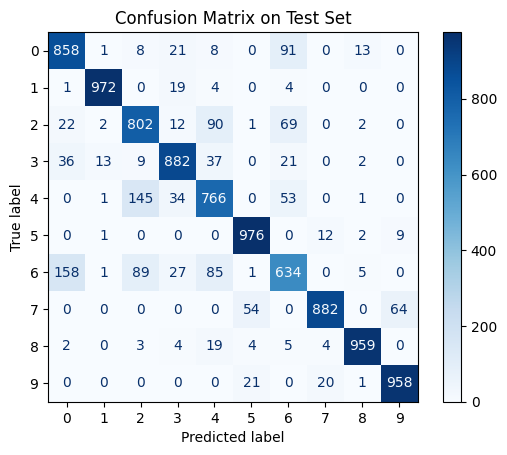

In [33]:
# Initialize model
loss_choice = "cross_entropy"
model = NeuralNetAdam(input_size=x_train.shape[1], hidden_size=128, output_size=num_classes, num_layers=4, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, loss_function=loss_choice)

# Train
train_losses, val_losses, train_accs, val_accs = model.train(x_train, y_train_onehot, x_val, y_val_onehot, epochs=10, batch_size=16)

# Compute test loss and accuracy
y_test_pred = model.forward(x_test)
test_loss = cross_entropy(y_test_onehot, y_test_pred) if loss_choice == "cross_entropy" else mse(y_test_onehot, y_test_pred)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
test_acc = accuracy_score(y_test, y_test_pred_labels)

# Print test metrics
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Plot confusion matrix
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Best Model")

wandb.init(project="DeepLearning1", name="confusion matrix best model")

# Save figure before logging
plt.savefig("confusion_matrix_best.png")  
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "confusion_matrix_best": wandb.Image("confusion_matrix_best.png")  # Log saved image
})

# Finish wandb run
wandb.finish()



# Comparing best model with cross entropy loss against MSE loss with same parameters

In [34]:
# Initialize model
loss_choice = "mse"
model = NeuralNetAdam(input_size=x_train.shape[1], hidden_size=128, output_size=num_classes, num_layers=4, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, loss_function=loss_choice)

# Train
train_losses_mse, val_losses_mse, train_accs_mse, val_accs_mse = model.train(x_train, y_train_onehot, x_val, y_val_onehot, epochs=10, batch_size=16)

# Compute test loss and accuracy
y_test_pred = model.forward(x_test)
test_loss = cross_entropy(y_test_onehot, y_test_pred) if loss_choice == "cross_entropy" else mse(y_test_onehot, y_test_pred)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
test_acc = accuracy_score(y_test, y_test_pred_labels)

# Print test metrics
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Predict test labels
y_pred_probs = model.forward(x_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure explicitly
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix with MSE")

wandb.init(project="DeepLearning1", name="confusion matrix for MSE")

# Save figure before logging
plt.savefig("confusion_matrix_MSE.png")  
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "confusion_matrix_MSE": wandb.Image("confusion_matrix_MSE.png")  # Log saved image
})

# Show the plot
plt.show()


Epoch 1/10 | Train Loss: 0.0218 | Train Acc: 0.8576 | Val Loss: 0.0219 | Val Acc: 0.8558
Epoch 2/10 | Train Loss: 0.0214 | Train Acc: 0.8592 | Val Loss: 0.0224 | Val Acc: 0.8548
Epoch 3/10 | Train Loss: 0.0182 | Train Acc: 0.8824 | Val Loss: 0.0193 | Val Acc: 0.8747
Epoch 4/10 | Train Loss: 0.0184 | Train Acc: 0.8734 | Val Loss: 0.0193 | Val Acc: 0.8658
Epoch 5/10 | Train Loss: 0.0171 | Train Acc: 0.8918 | Val Loss: 0.0188 | Val Acc: 0.8778
Epoch 6/10 | Train Loss: 0.0165 | Train Acc: 0.8926 | Val Loss: 0.0188 | Val Acc: 0.8782
Epoch 7/10 | Train Loss: 0.0163 | Train Acc: 0.8925 | Val Loss: 0.0183 | Val Acc: 0.8770
Epoch 8/10 | Train Loss: 0.0166 | Train Acc: 0.8940 | Val Loss: 0.0189 | Val Acc: 0.8772
Epoch 9/10 | Train Loss: 0.0162 | Train Acc: 0.8968 | Val Loss: 0.0187 | Val Acc: 0.8797
Epoch 10/10 | Train Loss: 0.0160 | Train Acc: 0.8984 | Val Loss: 0.0185 | Val Acc: 0.8798

Test Loss: 0.0199 | Test Accuracy: 0.8710


# comparing train loss, train accuracy, val loss and val accuracy for MSE and Cross Entropy Loss

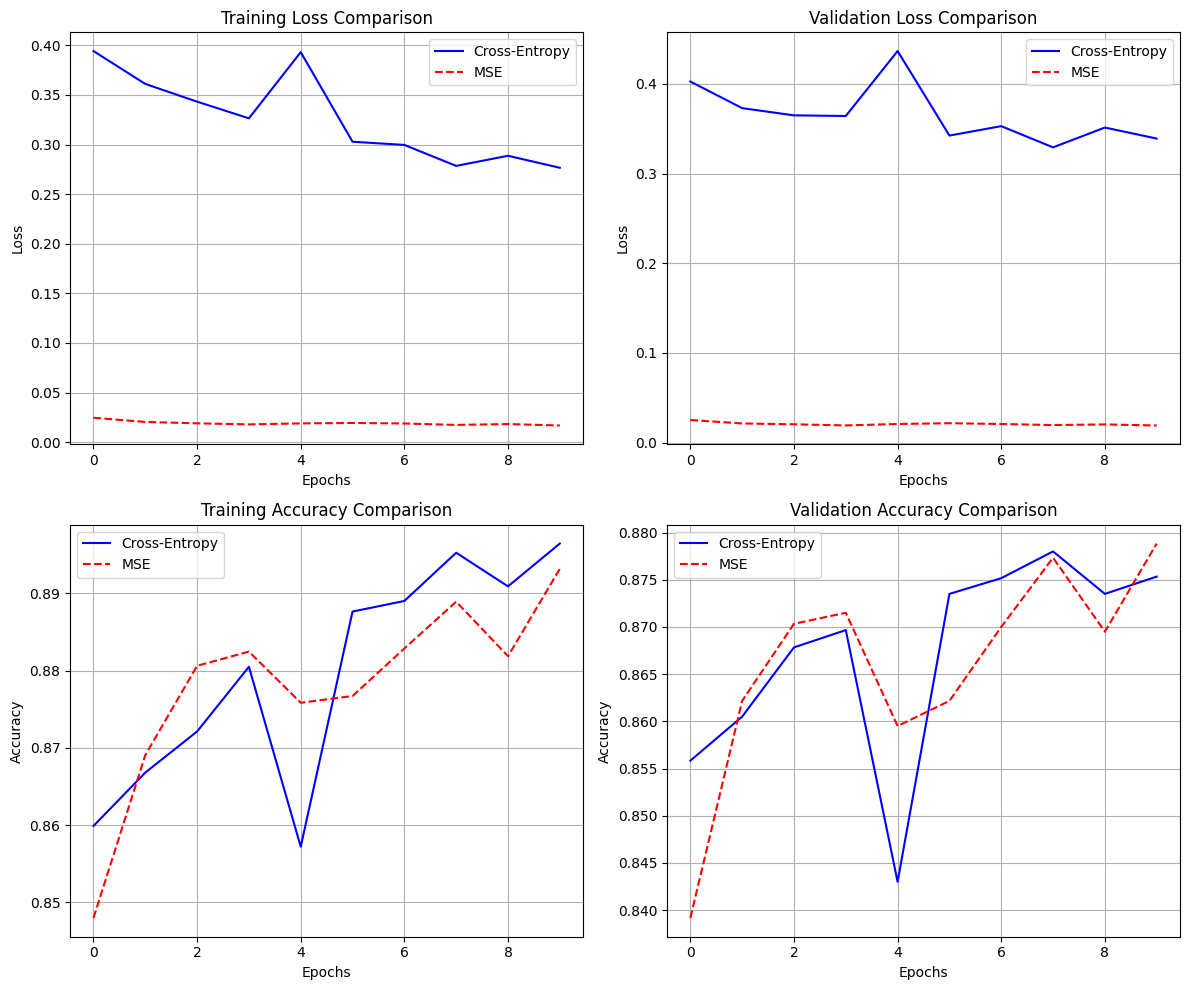

In [7]:
# Create subplots for loss and accuracy comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss Comparison
axes[0, 0].plot(train_losses, label="Cross-Entropy", color="blue")
axes[0, 0].plot(train_losses_mse, label="MSE", color="red", linestyle="dashed")
axes[0, 0].set_title("Training Loss Comparison")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid()

# Validation Loss Comparison
axes[0, 1].plot(val_losses, label="Cross-Entropy", color="blue")
axes[0, 1].plot(val_losses_mse, label="MSE", color="red", linestyle="dashed")
axes[0, 1].set_title("Validation Loss Comparison")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid()

# Training Accuracy Comparison
axes[1, 0].plot(train_accs, label="Cross-Entropy", color="blue")
axes[1, 0].plot(train_accs_mse, label="MSE", color="red", linestyle="dashed")
axes[1, 0].set_title("Training Accuracy Comparison")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].legend()
axes[1, 0].grid()

# Validation Accuracy Comparison
axes[1, 1].plot(val_accs, label="Cross-Entropy", color="blue")
axes[1, 1].plot(val_accs_mse, label="MSE", color="red", linestyle="dashed")
axes[1, 1].set_title("Validation Accuracy Comparison")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].legend()
axes[1, 1].grid()

# # Adjust layout and display
# plt.tight_layout()
# plt.show()
wandb.init(project="DeepLearning1", name="MSE_vs_CE_Comparison")

# Save plot as image
plt.tight_layout()
plot_path = "loss_accuracy_comparison.png"
plt.savefig(plot_path)

# Log image to wandb
wandb.log({"Loss & Accuracy Comparison": wandb.Image(plot_path)})

# Show plot
plt.show()

In [19]:
wandb.init(project="DeepLearning1", name="MSE_vs_CE_Comparison")

# Save plot as image
plt.tight_layout()
plot_path = "loss_accuracy_comparison.png"
plt.savefig(plot_path)

# Log image to wandb
wandb.log({"Loss & Accuracy Comparison": wandb.Image(plot_path)})

# Show plot
plt.show()

<Figure size 640x480 with 0 Axes>